In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import csv
from collections import defaultdict, Counter
import json
from datetime import datetime
import seaborn as sns
import os
import statsmodels.formula.api as smf
import random
import matplotlib.pyplot as plt
import scipy.stats as stats
import ast
from datasets import load_dataset

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Load Model Responses

In [4]:
pred_subset_df = pd.read_csv(Path.cwd().parent / "data" / "pred_subset.csv")

In [5]:
with open(Path.cwd().parent / "data" / "answer_mapping.json", 'r') as infile: 
    answer_mapping0 = json.load(infile)

answer_mapping = {}
for ans in answer_mapping0:
    answer_mapping[ans.strip()] = answer_mapping0[ans]

error_question_df = pred_subset_df[pred_subset_df['Question'] == 'What errors does the student make in their response? If there are none, write that there is no error']
answers = error_question_df.groupby('Image Name')['Reference Answer'].agg(list).to_dict()

no_error = []
has_error = []
for ans in answer_mapping:
    if answer_mapping[ans] == 'no': 
        no_error.append(ans)
    elif answer_mapping[ans] == 'yes': 
        has_error.append(ans)

binary_answers = {}
for image in answers: 
    answers[image] = set(answers[image])
    if len(answers[image]) != 1:
        print(image, answers[image])
    assert len(answers[image]) == 1
    ans = list(answers[image])[0]
    if answer_mapping[ans] == 'no': 
        binary_answers[image] = 'no error'
    else: 
        binary_answers[image] = 'error'
print("Number of images with errors:", Counter(binary_answers.values()))

pred_subset_df['Has Error'] = pred_subset_df['Image Name'].apply(lambda x: binary_answers[x])

Number of images with errors: Counter({'no error': 1118, 'error': 912})


In [6]:
question_cat_file = Path.cwd().parent / "data" / "questions_to_categories.json"
with open(question_cat_file, 'r') as infile:
    question_to_category = json.load(infile)

def map_to_question_cat(q): 
    q = q.strip()
    if q.startswith('What errors does the student make in their response?'): 
        q = 'What errors does the student make in their response?'
    return question_to_category[q]

def map_to_broader_question_cat(cat): 
    if cat == 'Correctness and errors' or cat == 'Image creation and medium': 
        return cat
    else: 
        return 'Content description'

pred_subset_df['Question Cat'] = pred_subset_df['Question'].apply(map_to_question_cat)
pred_subset_df['Question Cat 2'] = pred_subset_df['Question Cat'].apply(map_to_broader_question_cat)
pred_subset_df['Question Cat'].unique()

array(['Correctness and errors',
       'Low-level characteristics, composition, and positioning',
       'Writing and labels',
       'Problem solving steps, strategy, and solution',
       'Higher-level understanding of math concepts', 'Counting content',
       'Image creation and medium', 'Other'], dtype=object)

In [7]:
def clean_up_scores(row): 
    s = row['LLM Score Rating']
    if s in ['1', '2', 1, 2]: 
        s = 0
    elif s in ['3', '4', 3, 4]:
        s = 1
    if s != 0 and s != 1: 
        s = -1
    return s

### Overall Results

In [8]:
release_date = {
    "Gemini 2.0 Flash": datetime.strptime("02-05-2025", '%m-%d-%Y'),
    "Gemini 2.5 Pro Preview": datetime.strptime("03-25-2025", '%m-%d-%Y'),
    "Gemini 2.5 Pro": datetime.strptime("06-17-2025", '%m-%d-%Y'),
    "GPT-4.1": datetime.strptime("04-14-2025", '%m-%d-%Y'),
    "GPT-4.5 Preview": datetime.strptime("02-27-2025", '%m-%d-%Y'),
    "o4 mini": datetime.strptime("04-16-2025", '%m-%d-%Y'),
    "GPT-5": datetime.strptime("08-07-2025", '%m-%d-%Y'),
    "Claude Sonnet 3.7": datetime.strptime("04-24-2025", '%m-%d-%Y'),
    "Claude Sonnet 4": datetime.strptime("05-22-2025", '%m-%d-%Y'),
    "Claude Sonnet 4.5": datetime.strptime("09-29-2025", '%m-%d-%Y'),
    "Llama 4 Scout": datetime.strptime("04-05-2025", '%m-%d-%Y'),
}

model_family = {
    "Gemini 2.0 Flash": 'Google',
    "Gemini 2.5 Pro Preview": 'Google',
    "Gemini 2.5 Pro": 'Google',
    "GPT-4.1": 'OpenAI',
    "GPT-4.5 Preview": 'OpenAI',
    "o4 mini": 'OpenAI',
    "GPT-5": 'OpenAI',
    "Claude Sonnet 3.7": 'Anthropic',
    "Claude Sonnet 4": 'Anthropic',
    "Claude Sonnet 4.5": 'Anthropic',
    "Llama 4 Scout": 'Meta',
}

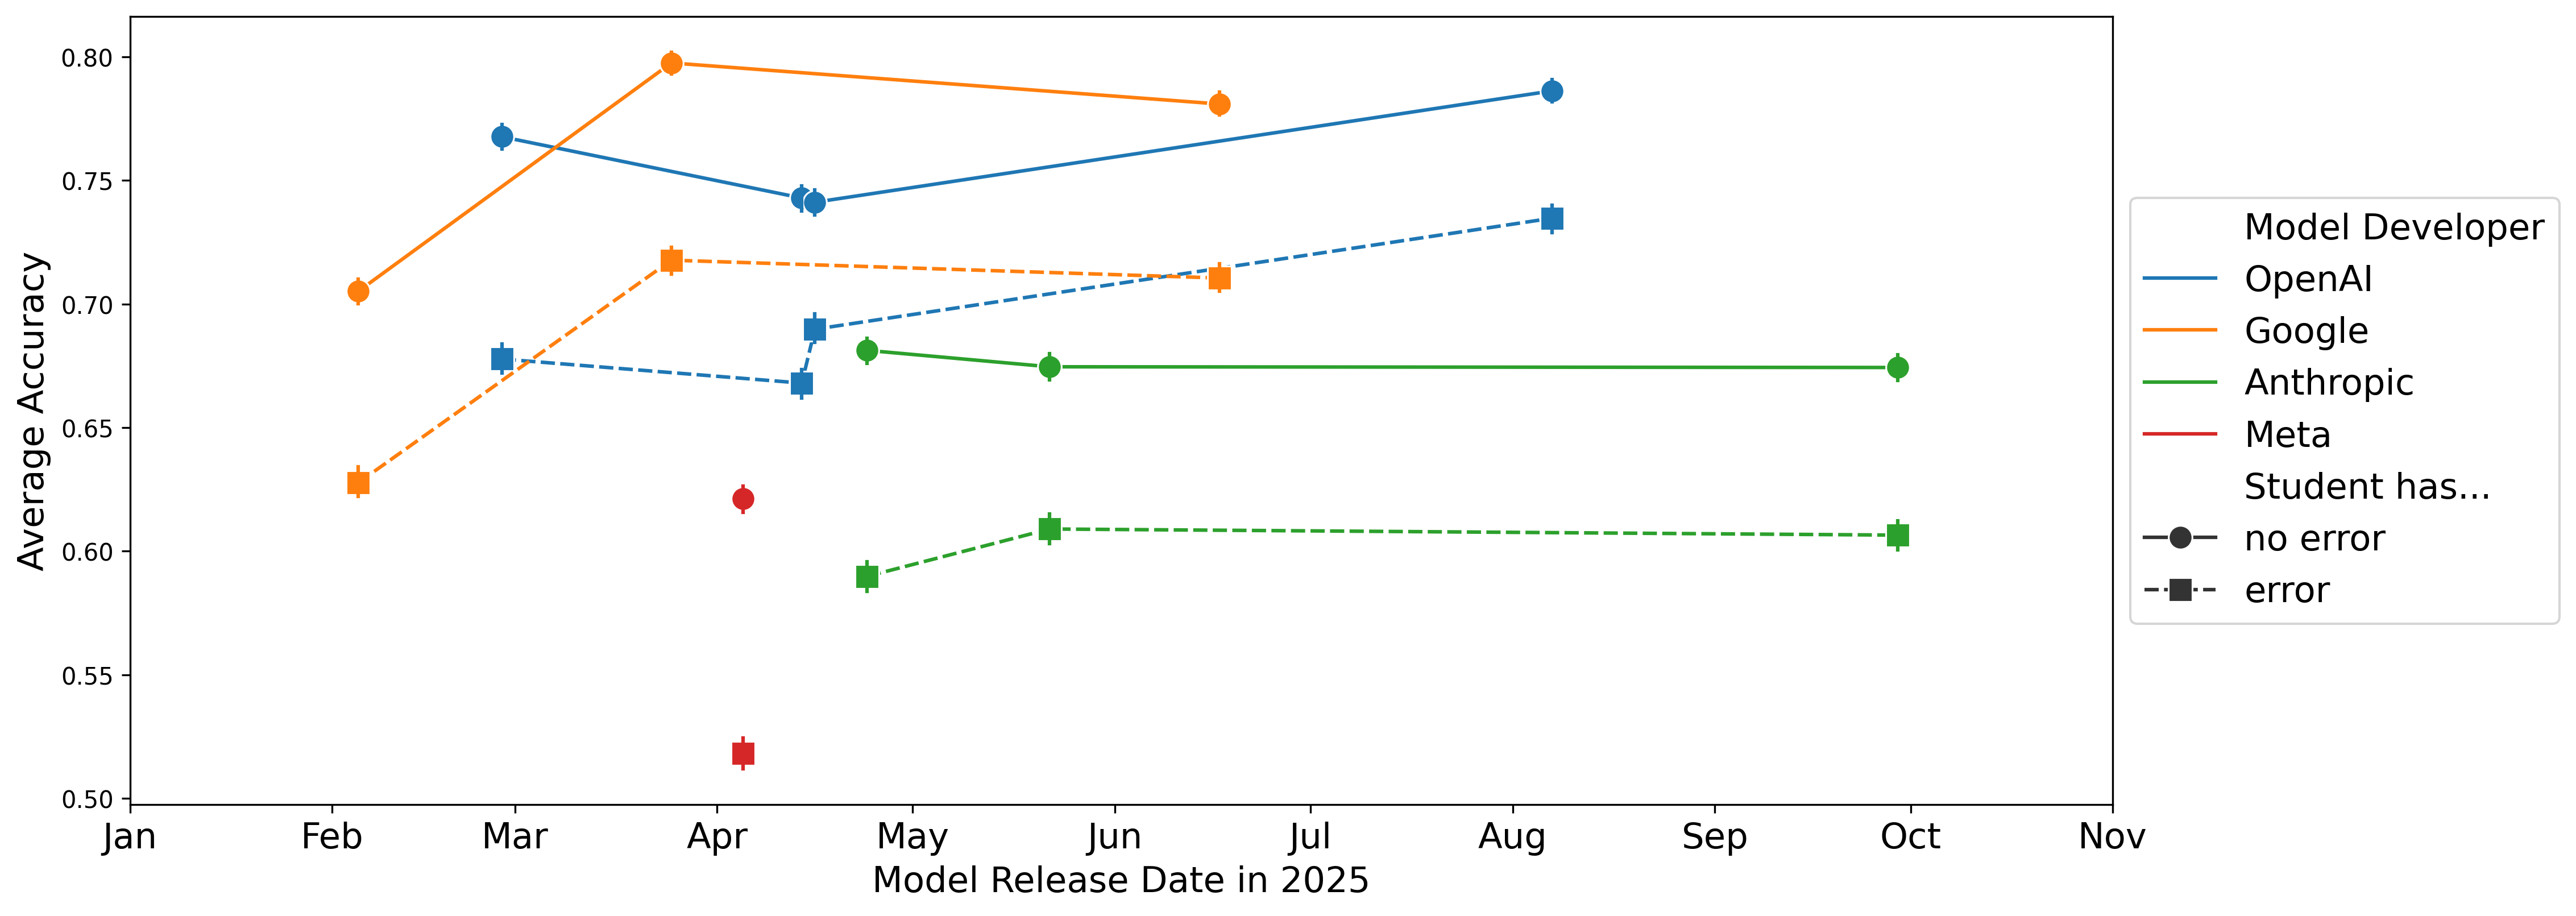

In [9]:
# a plot of model performance over time, disaggregated by marker for Has Error, where each model family is a different color
# add vertical lines that indicate the performance gap between Has Error and No Error for each model
pred_subset_df['Release Date'] = pred_subset_df['Model Name'].apply(lambda x: release_date[x])
pred_subset_df['Model Developer'] = pred_subset_df['Model Name'].apply(lambda x: model_family[x])
plt.figure(figsize=(15, 6))
ax = sns.lineplot(data=pred_subset_df, x="Release Date", y="Score", style="Has Error", 
                  hue="Model Developer", markers=['o', 's'], dashes=True, markersize=10, err_style="bars")
plt.xlabel("Model Release Date in 2025", fontsize=15)
plt.ylabel("Average Accuracy", fontsize=15)
plt.xlim(datetime.strptime("01-01-2025", '%m-%d-%Y'), datetime.strptime("10-01-2025", '%m-%d-%Y'))
# x ticks should be names of months from Jan to Nov
plt.xticks([datetime.strptime(f"{month}-01-2025", '%m-%d-%Y') for month in range(1, 12)], 
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'], 
           fontsize=15)
# move legend to below the bottom 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15)
legend = ax.get_legend()
for text in legend.get_texts():
    if text.get_text() == "Has Error":
        text.set_text("Student has...")
plt.gcf().set_dpi(300)
plt.show() 

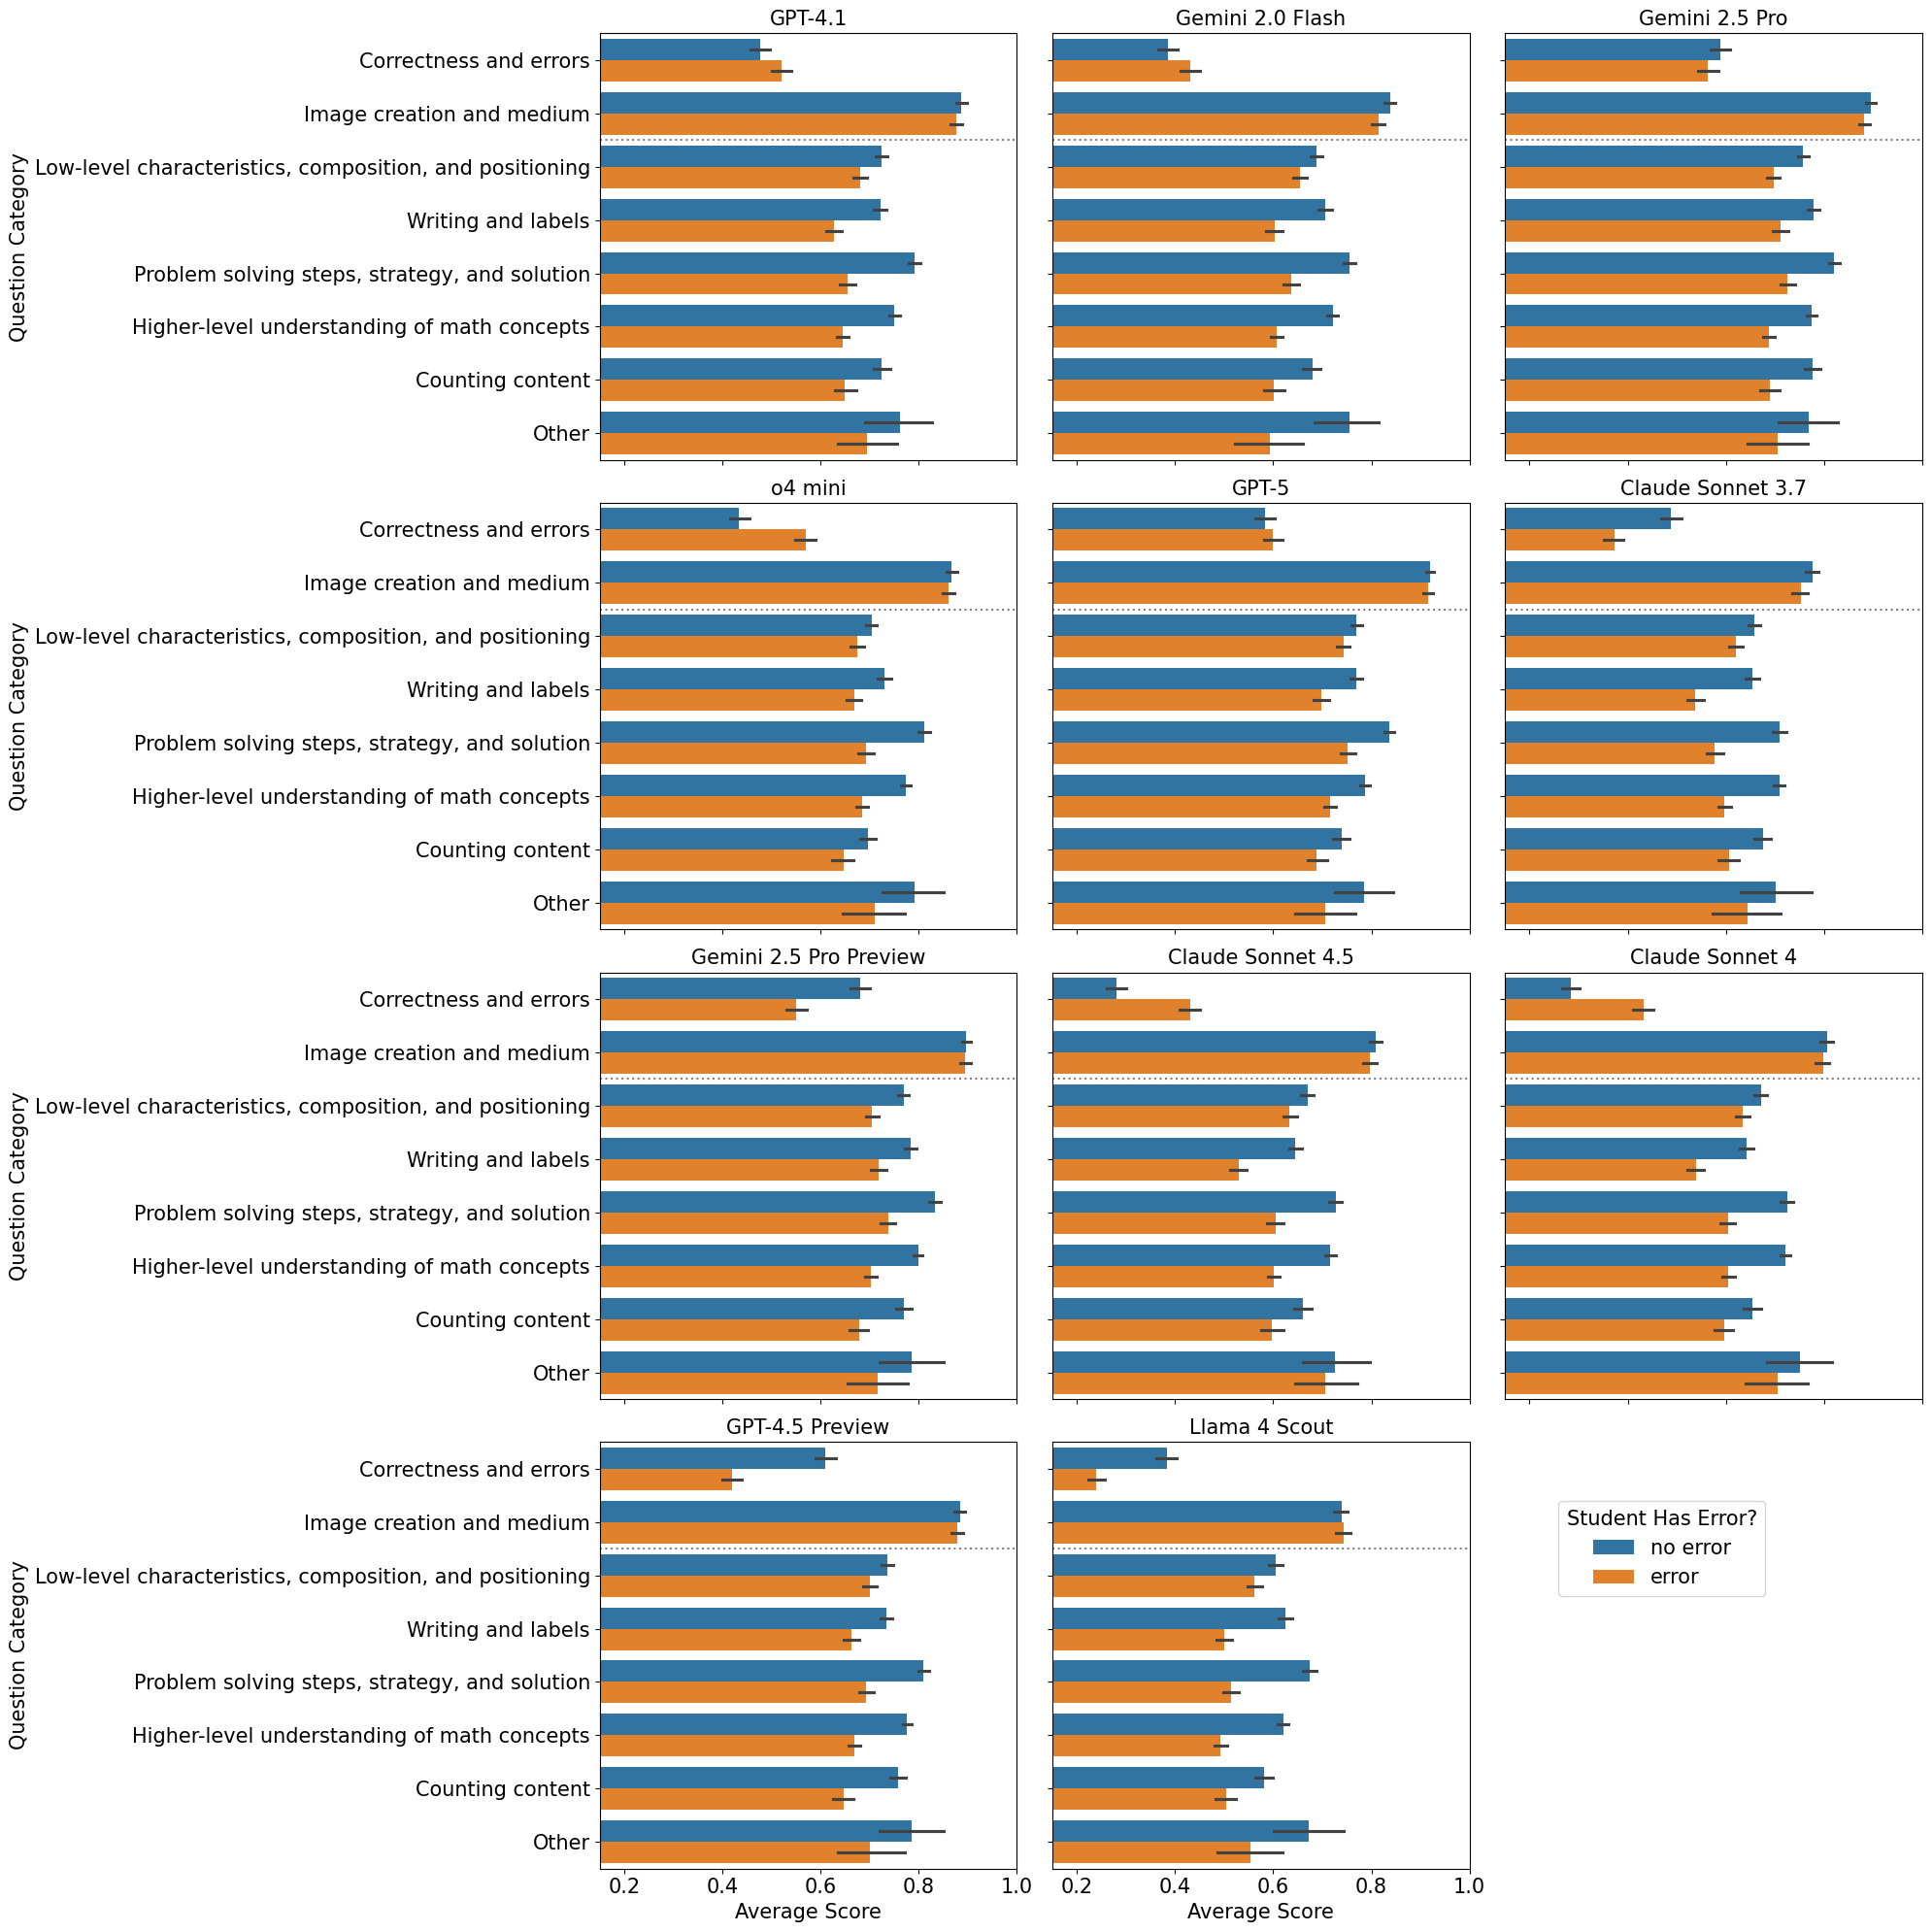

In [10]:
order = [
    'Correctness and errors',
    'Image creation and medium',
    'Low-level characteristics, composition, and positioning',
    'Writing and labels',
    'Problem solving steps, strategy, and solution',
    'Higher-level understanding of math concepts',
    'Counting content',
    'Other'
]

models = pred_subset_df['Model Name'].unique()

# --- Create 2x6 grid
fig, axes = plt.subplots(
    nrows=4,
    ncols=3,
    figsize=(20, 20), 
    sharex=True,
    sharey=True
)

axes = axes.flatten()  # makes indexing easy

for i, model_name in enumerate(models):
    model_data = pred_subset_df[
        pred_subset_df['Model Name'] == model_name
    ]

    ax = axes[i]

    sns.barplot(
        data=model_data,
        x="Score",
        y="Question Cat",
        hue="Has Error",
        order=order,
        ax=ax
    )

    # --- Dotted separator after "Image creation and medium"
    idx = order.index('Image creation and medium')
    ax.axhline(
        y=idx + 0.5,
        color='gray',
        linestyle=':',
        linewidth=1.5
    )

    ax.set_title(model_name, fontsize=15)
    ax.set_xlim(0.15, 1)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)
    ax.set_ylabel("Question Category", fontsize=15)
    ax.set_xlabel("Average Score", fontsize=15)
    # remove legend from individual plots
    ax.legend_.remove()

# --- Remove unused subplots if < 12 models
for j in range(len(models), len(axes)):
    fig.delaxes(axes[j])
# add single legend for entire figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc='center left',
    bbox_to_anchor=(0.8, 0.2),
    title="Student Has Error?",
    title_fontsize=15,
    fontsize=15
)

plt.tight_layout()
plt.show()

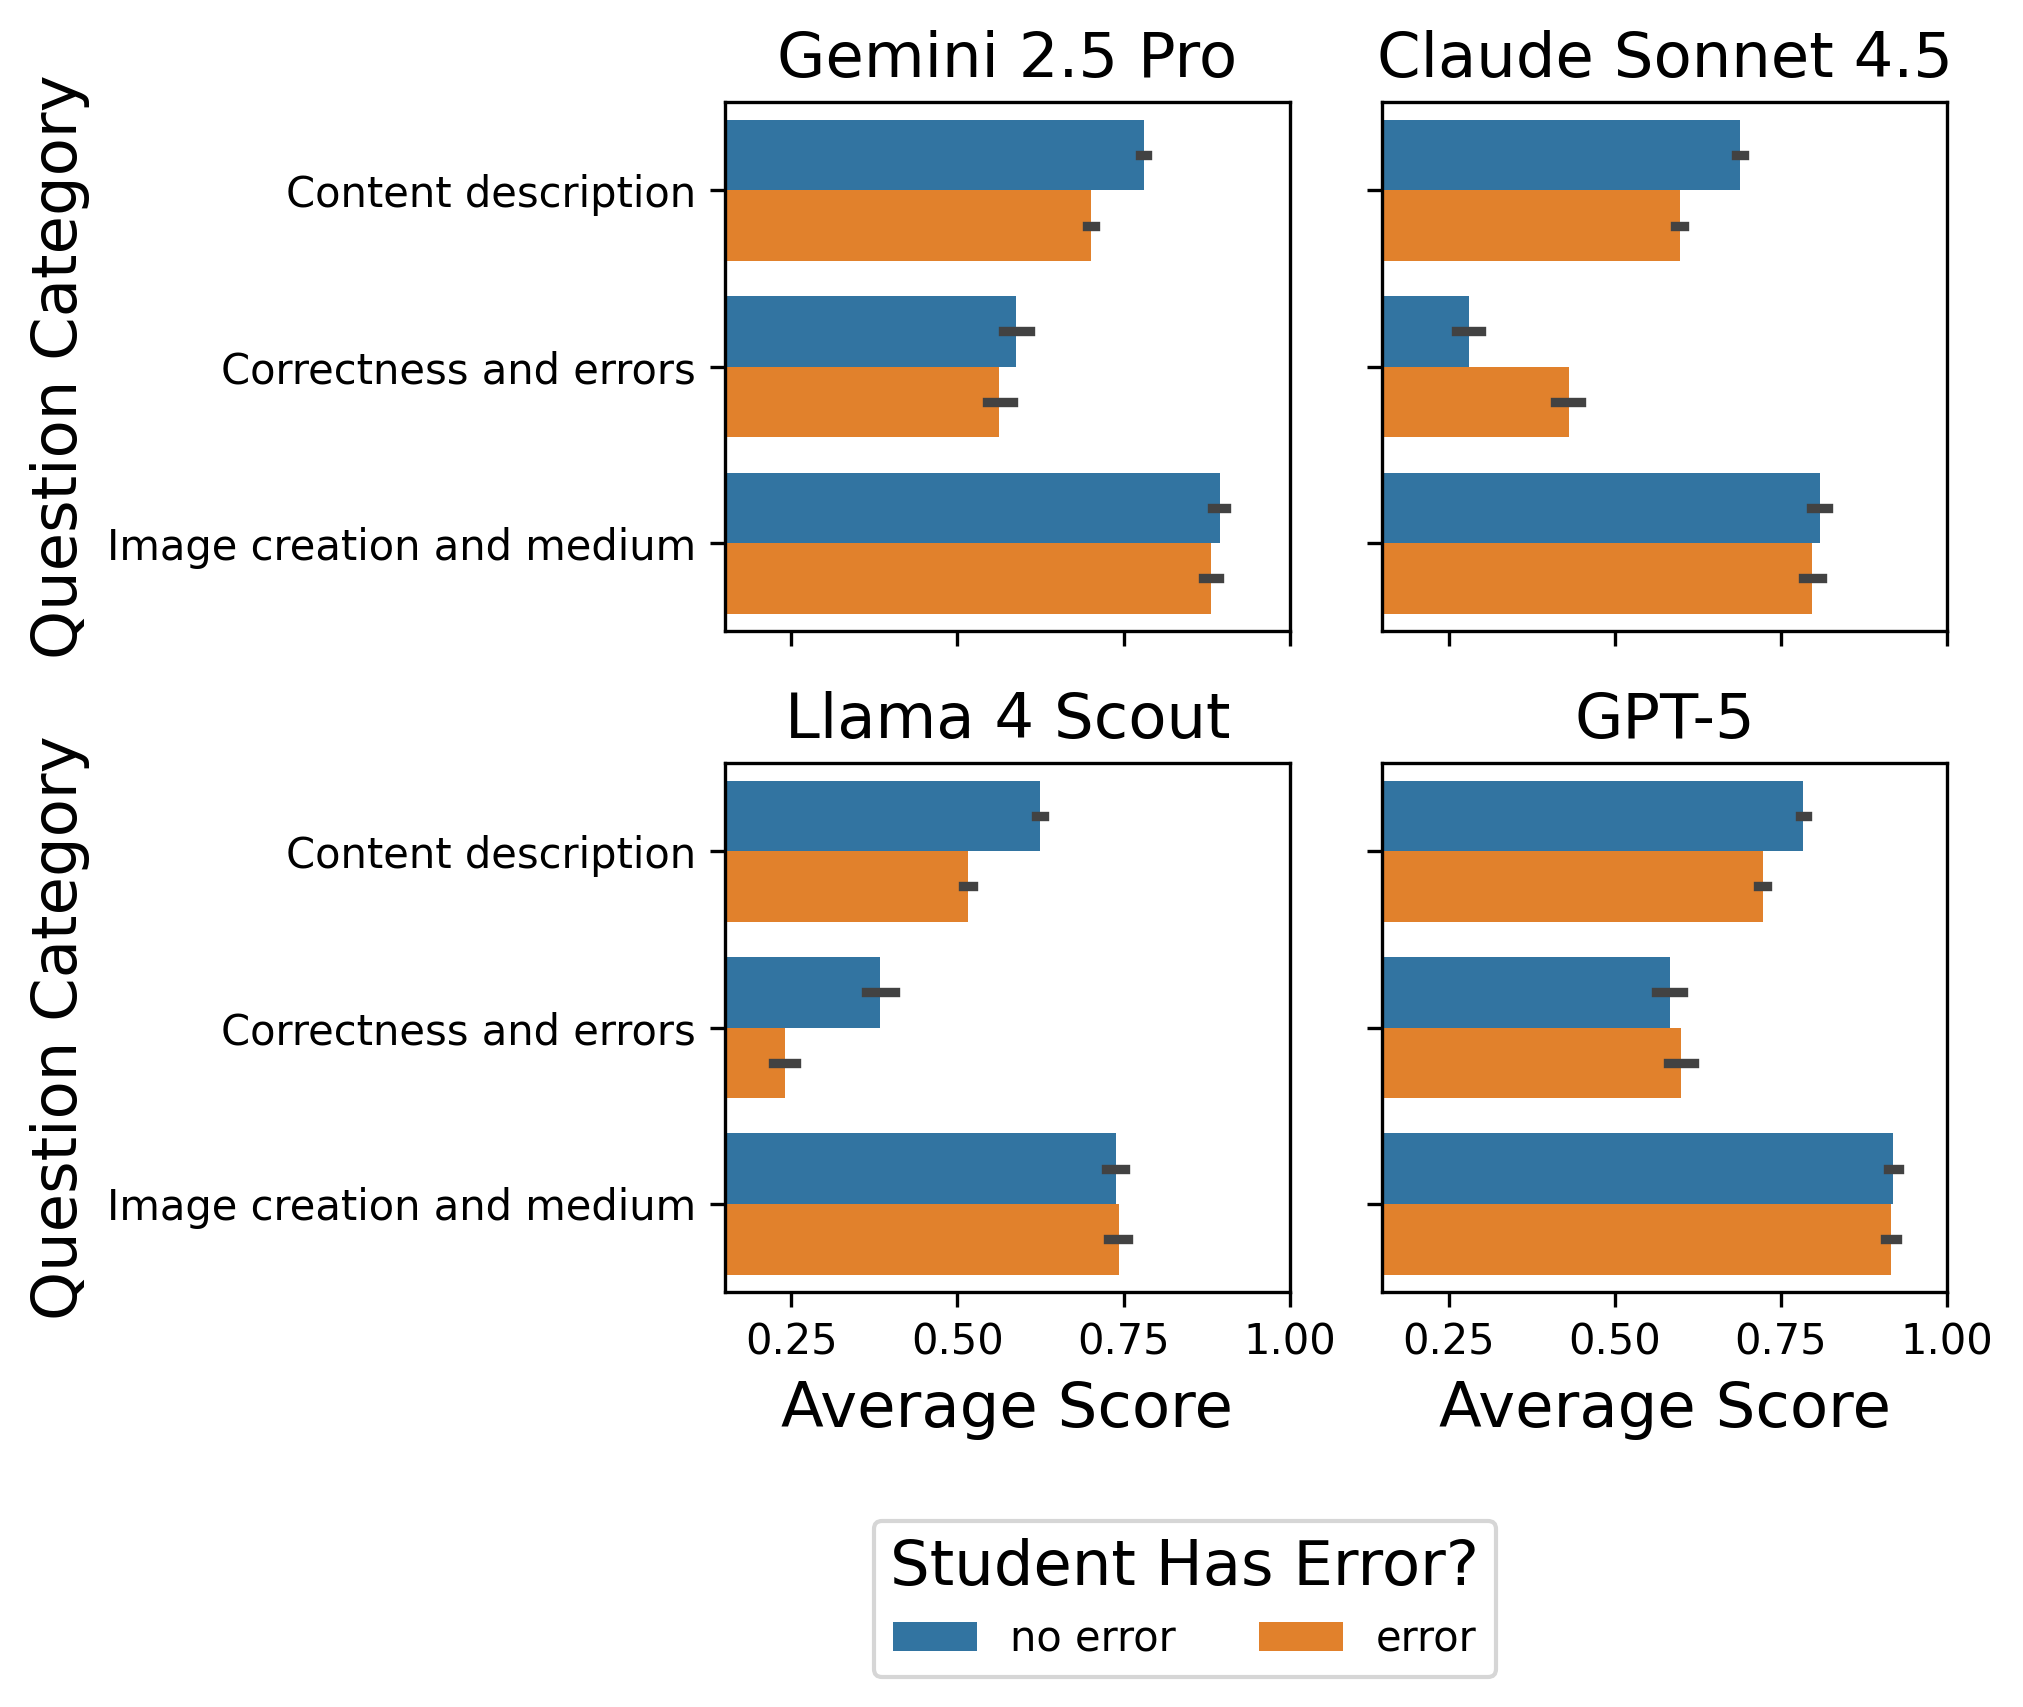

In [11]:
models_to_plot = [
    'Gemini 2.5 Pro',
    'Claude Sonnet 4.5',
    'Llama 4 Scout',
    'GPT-5'
]
this_df = pred_subset_df[
    pred_subset_df['Model Name'].isin(models_to_plot)
]

fig, axes = plt.subplots(
    2, 2,
    figsize=(8, 5),
    dpi=300,
    sharey=True,
    sharex=True
)
axes = axes.flatten()
for ax, model_name in zip(axes, models_to_plot):
    model_data = this_df[
        this_df['Model Name'] == model_name
    ]
    sns.barplot(
        data=model_data,
        x="Score",
        y="Question Cat 2",
        hue="Has Error",
        order=['Content description', 'Correctness and errors', 'Image creation and medium'],
        ax=ax
    )
    ax.set_title(model_name, fontsize=15)
    ax.set_xlabel("Average Score", fontsize=15)
    ax.set_ylabel("Question Category", fontsize=15)
    ax.set_xlim(0.15, 1)   # matches your heatmap scale

    # Clean up legends (keep only one)
    ax.get_legend().remove()
# Single shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="Student Has Error?",
    title_fontsize=15,
    loc="upper center",          
    bbox_to_anchor=(0.5, -0.01),
    ncol=2
)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

### Controlling for Problem

In [12]:
content_qa_df = pred_subset_df[~pred_subset_df['Question Cat'].isin(['Correctness and errors', 'Image creation and medium'])]

In [13]:
for model_name in content_qa_df['Model Name'].unique():
    this_model_df = content_qa_df[content_qa_df['Model Name'] == model_name]
    this_model_df = this_model_df[['Problem ID', 'Has Error', 'Score', 'Image Name']].groupby(['Problem ID', 'Has Error', 'Image Name']).agg(['mean']).reset_index()
    assert len(this_model_df['Image Name'].unique()) == len(this_model_df)
    this_model_df.columns = this_model_df.columns.get_level_values(0) # drop "mean" column from multiindex
    this_model_df = this_model_df.rename(columns={'Has Error': 'Correct', 'Problem ID': 'Problem_ID'})
    this_model_df['Correct'] = this_model_df['Correct'].apply(lambda x: 0 if x == 'error' else 1)
    m = smf.ols("Score ~ Correct + C(Problem_ID)", data=this_model_df).fit()
    print(model_name, '\t', round(m.params['Correct'], 4), '\t', m.pvalues['Correct'])

GPT-4.1 	 0.0865 	 4.597713968322948e-23
Gemini 2.0 Flash 	 0.0944 	 4.949956272232489e-21
Gemini 2.5 Pro 	 0.0889 	 2.9515096300856243e-18
o4 mini 	 0.0612 	 3.973700138169494e-13
GPT-5 	 0.0585 	 5.507994178974876e-13
Claude Sonnet 3.7 	 0.0922 	 2.071259121847687e-26
Gemini 2.5 Pro Preview 	 0.0888 	 3.18363461051287e-20
Claude Sonnet 4.5 	 0.0842 	 8.74966219470466e-24
Claude Sonnet 4 	 0.0816 	 5.572071622497561e-22
GPT-4.5 Preview 	 0.0874 	 9.220717755449003e-27
Llama 4 Scout 	 0.1013 	 1.9541903119347024e-29


### Sampling for Redrawing

In [14]:
def get_samples_of_images(problem_to_images, seed=0): 
    sample_file = Path.cwd().parent / "data" / "sampled_images_per_problem.json"
    print("Loading from file...")
    with open(sample_file, 'r') as infile: 
        sampled_N_images = json.load(infile)
    return sampled_N_images

In [15]:
this_df = pred_subset_df[['Model Name', 'Problem ID', 'Image Name', 'Has Error', 'Question', 'Reference Answer', 'Question Cat', 'Score']]
# get mapping from Problem ID to list of unique Image Name
problem_to_images = this_df.groupby(['Problem ID', 'Has Error'])['Image Name'].unique().apply(list).to_dict()
# sample N error image and N non-error image per problem
sampled_N_images = get_samples_of_images(problem_to_images, seed=0) 

Loading from file...


In [16]:
keep = set()
for im in sampled_N_images['1']: 
    name_without_extension, extension = os.path.splitext(im)
    keep.add(name_without_extension)
print(len(keep))

336


In [17]:
exp1_df = pred_subset_df[pred_subset_df['Image Name'].apply(lambda x: x.split('.')[0] in keep)]
exp1_df = exp1_df[exp1_df['Question Cat'] != 'Image creation and medium']
exp1_df['Question Cat 2'] = exp1_df['Question Cat'].apply(lambda x: 'Correctness and errors' if x == 'Correctness and errors' else 'Content description')
exp1_original_df = exp1_df[exp1_df['Model Name'].isin(['Claude Sonnet 4.5', 'GPT-5', 'Gemini 2.5 Pro', 'Llama 4 Scout'])]
exp1_original_df['Results'] = 'original'

/var/folders/hh/syyyddsn7w33p6pntgdg0yq00000gn/T/ipykernel_79847/135226382.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp1_original_df['Results'] = 'original'


In [18]:
def calculate_diff_in_means(input_df): 
    noncorr_df = input_df[input_df['Question Cat'] != 'Correctness and errors']
    for model_name in noncorr_df['Model Name'].unique(): 
        this_model_df = noncorr_df[noncorr_df['Model Name'] == model_name]
        this_model_df = this_model_df.groupby(['Has Error', 'Image Name'])['Score'].agg('mean').reset_index()
        error_list = this_model_df[this_model_df['Has Error'] == 'error']['Score'].to_list()
        no_error_list = this_model_df[this_model_df['Has Error'] == 'no error']['Score'].to_list()
        assert len(error_list) == len(no_error_list)
        mean1 = np.mean(error_list)
        mean2 = np.mean(no_error_list)
        result = stats.ttest_ind(error_list, no_error_list)
        print('\t', model_name, '\t', f"{mean1:.4f}", '\t', f"{mean2:.4f}", '\t', f"Diff in means: {mean1 - mean2:.3f}. p-value: {result.pvalue:.3f}")

In [19]:
calculate_diff_in_means(exp1_df)

	 GPT-4.1 	 0.6529 	 0.7470 	 Diff in means: -0.094. p-value: 0.000
	 Gemini 2.0 Flash 	 0.6327 	 0.7267 	 Diff in means: -0.094. p-value: 0.000
	 Gemini 2.5 Pro 	 0.6916 	 0.7809 	 Diff in means: -0.089. p-value: 0.000
	 o4 mini 	 0.6800 	 0.7474 	 Diff in means: -0.067. p-value: 0.001
	 GPT-5 	 0.7308 	 0.7857 	 Diff in means: -0.055. p-value: 0.004
	 Claude Sonnet 3.7 	 0.6026 	 0.6923 	 Diff in means: -0.090. p-value: 0.000
	 Gemini 2.5 Pro Preview 	 0.7081 	 0.7943 	 Diff in means: -0.086. p-value: 0.000
	 Claude Sonnet 4.5 	 0.6003 	 0.7004 	 Diff in means: -0.100. p-value: 0.000
	 Claude Sonnet 4 	 0.6107 	 0.6937 	 Diff in means: -0.083. p-value: 0.000
	 GPT-4.5 Preview 	 0.6811 	 0.7674 	 Diff in means: -0.086. p-value: 0.000
	 Llama 4 Scout 	 0.5413 	 0.6336 	 Diff in means: -0.092. p-value: 0.000


In [20]:
exp1_redrawn_df = pd.read_csv(Path.cwd().parent / "data" / "exp1_redrawn.csv")

In [21]:
binary_answers_stem = {}
for image in answers: 
    ans = list(answers[image])[0] 
    if ans not in answer_mapping: 
        print("ISSUE:", image, ans)
        continue
    if answer_mapping[ans] == 'no': 
        image_stem = image.split('.')[0]
        binary_answers_stem[image_stem] = 'no error'
    else: 
        image_stem = image.split('.')[0]
        binary_answers_stem[image_stem] = 'error'

In [22]:
exp1_redrawn_df = exp1_redrawn_df[exp1_redrawn_df['Image Name'].apply(lambda x: x.split('.')[0] in keep)]
exp1_redrawn_df['Question Cat'] = exp1_redrawn_df['Question'].apply(map_to_question_cat)
exp1_redrawn_df = exp1_redrawn_df[exp1_redrawn_df['Question Cat'] != 'Image creation and medium']
exp1_redrawn_df['Question Cat 2'] = exp1_redrawn_df['Question Cat'].apply(lambda x: 'Correctness and errors' if x == 'Correctness and errors' else 'Content description')
exp1_redrawn_df['Has Error'] = exp1_redrawn_df['Image Name'].apply(lambda x: binary_answers_stem.get(x.split('.')[0], 'unknown'))
exp1_redrawn_df = exp1_redrawn_df.rename(columns={'Ensemble_Judge_Rating': 'LLM Score Rating', 'Reference Answer': 'Answer'})
exp1_redrawn_df['Score'] = exp1_redrawn_df.apply(clean_up_scores, axis=1)

In [23]:
calculate_diff_in_means(exp1_redrawn_df)

	 Gemini 2.5 Pro 	 0.7514 	 0.8219 	 Diff in means: -0.070. p-value: 0.000
	 GPT-5 	 0.7766 	 0.8274 	 Diff in means: -0.051. p-value: 0.001
	 Claude Sonnet 4.5 	 0.6882 	 0.7440 	 Diff in means: -0.056. p-value: 0.002
	 Llama 4 Scout 	 0.6186 	 0.6918 	 Diff in means: -0.073. p-value: 0.000


/var/folders/hh/syyyddsn7w33p6pntgdg0yq00000gn/T/ipykernel_79847/3368551380.py:6: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.pointplot(data=exp1_results[exp1_results['Question Cat 2'] == question_cat],
/var/folders/hh/syyyddsn7w33p6pntgdg0yq00000gn/T/ipykernel_79847/3368551380.py:6: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.pointplot(data=exp1_results[exp1_results['Question Cat 2'] == question_cat],


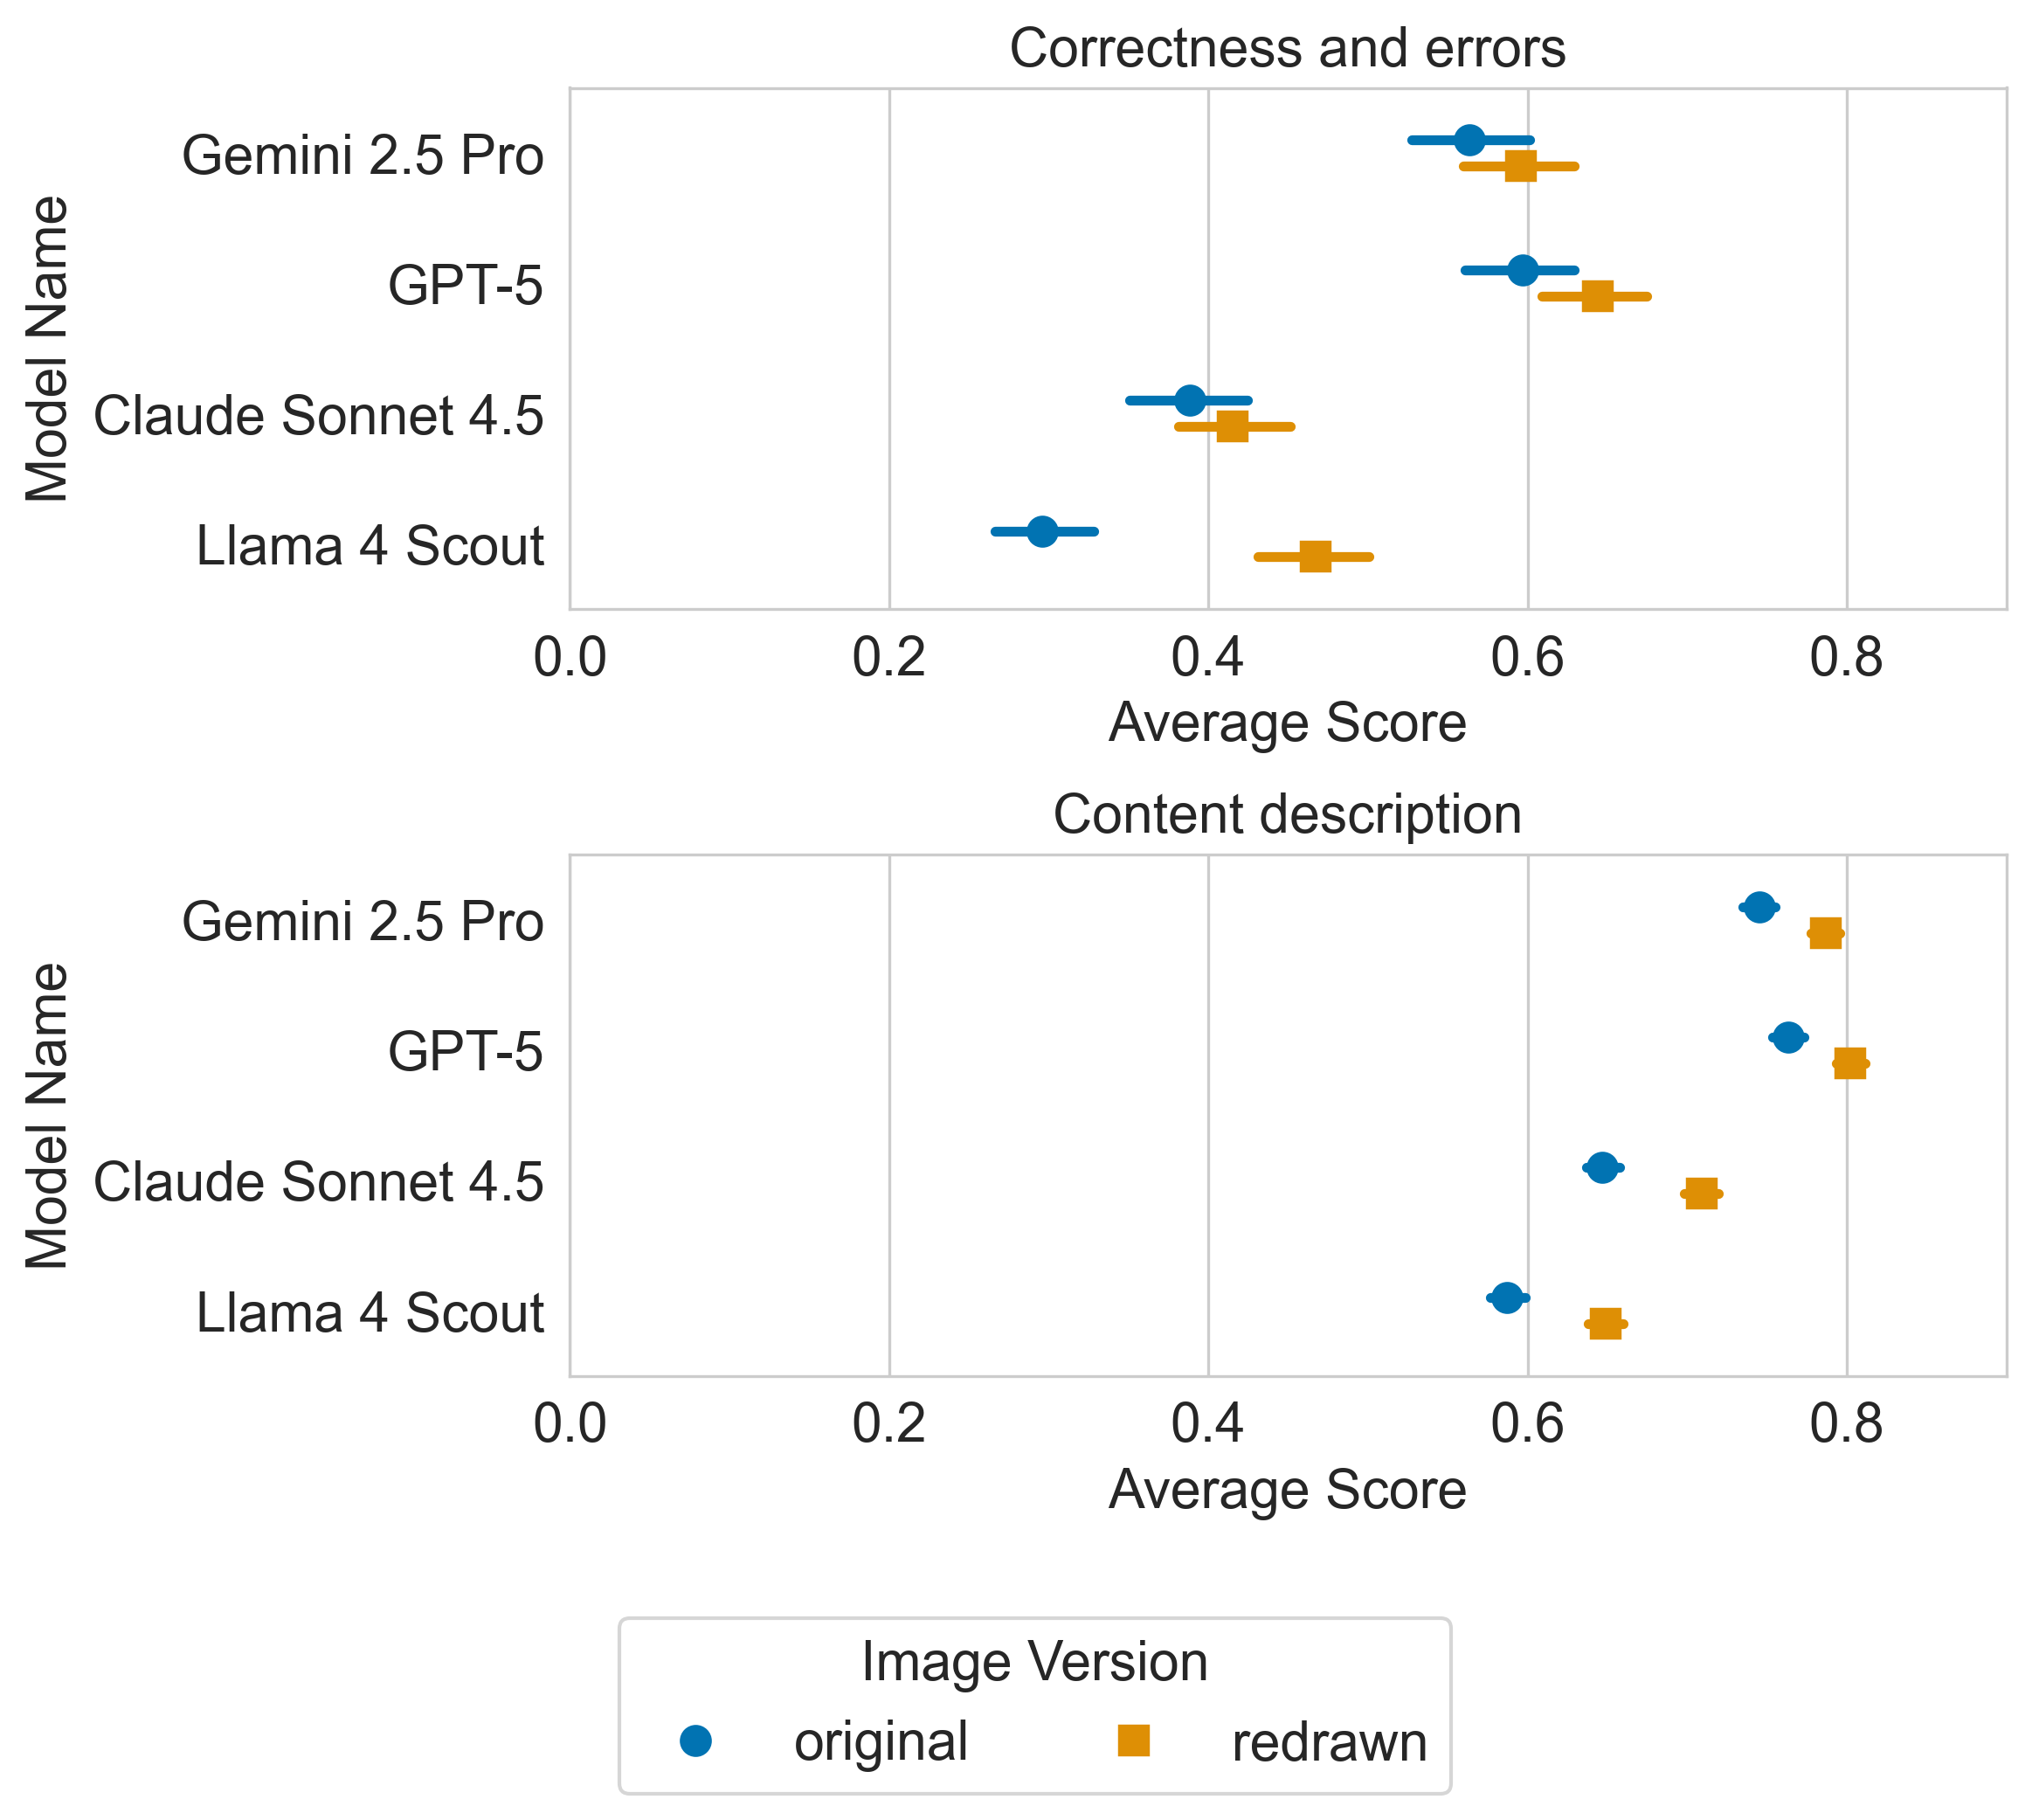

In [24]:
exp1_results = pd.concat([exp1_original_df, exp1_redrawn_df], ignore_index=True)
sns.set_style("whitegrid")
palette = sns.color_palette("colorblind")
fig, ax = plt.subplots(2, 1, sharey=True, figsize=(8, 6), dpi=300)
for i, question_cat in enumerate(exp1_results['Question Cat 2'].unique()):
    sns.pointplot(data=exp1_results[exp1_results['Question Cat 2'] == question_cat], 
                  y='Model Name', x='Score', markers = ['o', 's'],
                  dodge=0.2, linestyle="none", hue='Results', ax=ax[i], palette=palette)
    ax[i].get_legend().remove()
    ax[i].set_ylabel("Model Name", fontsize=15)
    ax[i].set_xlabel("Average Score", fontsize=15)
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    ax[i].tick_params(axis='both', which='minor', labelsize=15)
    ax[i].set_xlim(0, 0.9)
    ax[i].set_title(question_cat, fontsize=15)
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', title="Image Version", title_fontsize=15,
           bbox_to_anchor=(0.5, -0.02), ncol=2, fontsize=15)
plt.tight_layout()
plt.show()

### Adding textual support

In [25]:
ds = load_dataset("allenai/DrawEduMath", data_files="Data/DrawEduMath_QA.csv", split='train')

In [26]:
def load_qa_json(qa_pairs):
    try:
        qa = json.loads(qa_pairs)
        qa = ast.literal_eval(qa)

        return qa
    except:
        qa = json.loads(qa_pairs)
        return qa
    
def write_descriptions_with_correctness(ds):
    images_to_exclude = set()
    image_descriptions = {}
    for row in ds:
        image_name = row['Image Name']
        description = row['Image Caption']
        mentions_correctness = False
        qa = load_qa_json(row['QA Claude'].strip())
        for qa_dict in qa:
            question = qa_dict['question'].strip()
            cat = map_to_question_cat(question)
            if cat == 'Correctness and errors':
                mentions_correctness = True
                break
        
        qa = load_qa_json(row['QA GPT4o'].strip())
        for qa_dict in qa:
            question = qa_dict['question'].strip()
            cat = map_to_question_cat(question)
            if cat == 'Correctness and errors':
                mentions_correctness = True
                break

        if mentions_correctness: 
            images_to_exclude.add(image_name)
        else: 
            image_descriptions[image_name] = description
    return images_to_exclude, image_descriptions

images_to_exclude, image_descriptions = write_descriptions_with_correctness(ds)

In [27]:
exp2_df = pred_subset_df[~pred_subset_df['Image Name'].isin(images_to_exclude)]
exp2_df = exp2_df[exp2_df['Model Name'].isin(['Gemini 2.5 Pro', 'GPT-5' , 'Claude Sonnet 4.5', 'Llama 4 Scout'])]
print("Images remaining:", len(exp2_df['Image Name'].unique()))

Images remaining: 1769


In [28]:
exp2_df = exp2_df[exp2_df['Question Cat'] == 'Correctness and errors']
exp2_df['Model Name'].value_counts()

Model Name
Gemini 2.5 Pro       3253
GPT-5                3253
Claude Sonnet 4.5    3253
Llama 4 Scout        3253
Name: count, dtype: int64

In [29]:
exp2_nl_df = pd.read_csv(Path.cwd().parent / "data" / "exp2_nl.csv")
exp2_testtime_df = pd.read_csv(Path.cwd().parent / "data" / "exp2_testtime.csv")

In [30]:
exp2_nl_df = exp2_nl_df[['Model Name', 'Problem ID', 'QA Type', 'Image Name', 'Ensemble_Judge_Rating', 'Question', 'Reference Answer', 'Model Answer']]
exp2_nl_df = exp2_nl_df.rename(columns={'Ensemble_Judge_Rating': 'LLM Score Rating', 'Reference Answer': 'Answer'})
exp2_nl_df['Score'] = exp2_nl_df.apply(clean_up_scores, axis=1)
exp2_testtime_df = exp2_testtime_df[['Model Name', 'Problem ID', 'QA Type', 'Image Name', 'Ensemble_Judge_Rating', 'Question', 'Reference Answer', 'Model Answer']]
exp2_testtime_df = exp2_testtime_df.rename(columns={'Ensemble_Judge_Rating': 'LLM Score Rating', 'Reference Answer': 'Answer'})
exp2_testtime_df['Score'] = exp2_testtime_df.apply(clean_up_scores, axis=1)

In [44]:
exp2_df_other = pred_subset_df[~pred_subset_df['Image Name'].isin(images_to_exclude)]
exp2_df_other = exp2_df_other[exp2_df_other['Model Name'].isin(['Gemini 2.5 Pro', 'GPT-5' , 'Claude Sonnet 4.5', 'Llama 4 Scout'])]
exp2_df_other = exp2_df_other[exp2_df_other['Question Cat'] != 'Correctness and errors']
exp2_df_other['Results'] = 'Other QA w/o NLD'

/var/folders/hh/syyyddsn7w33p6pntgdg0yq00000gn/T/ipykernel_79847/3078109117.py:9: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.pointplot(data=exp2_results, y='Model Name', x='Score',


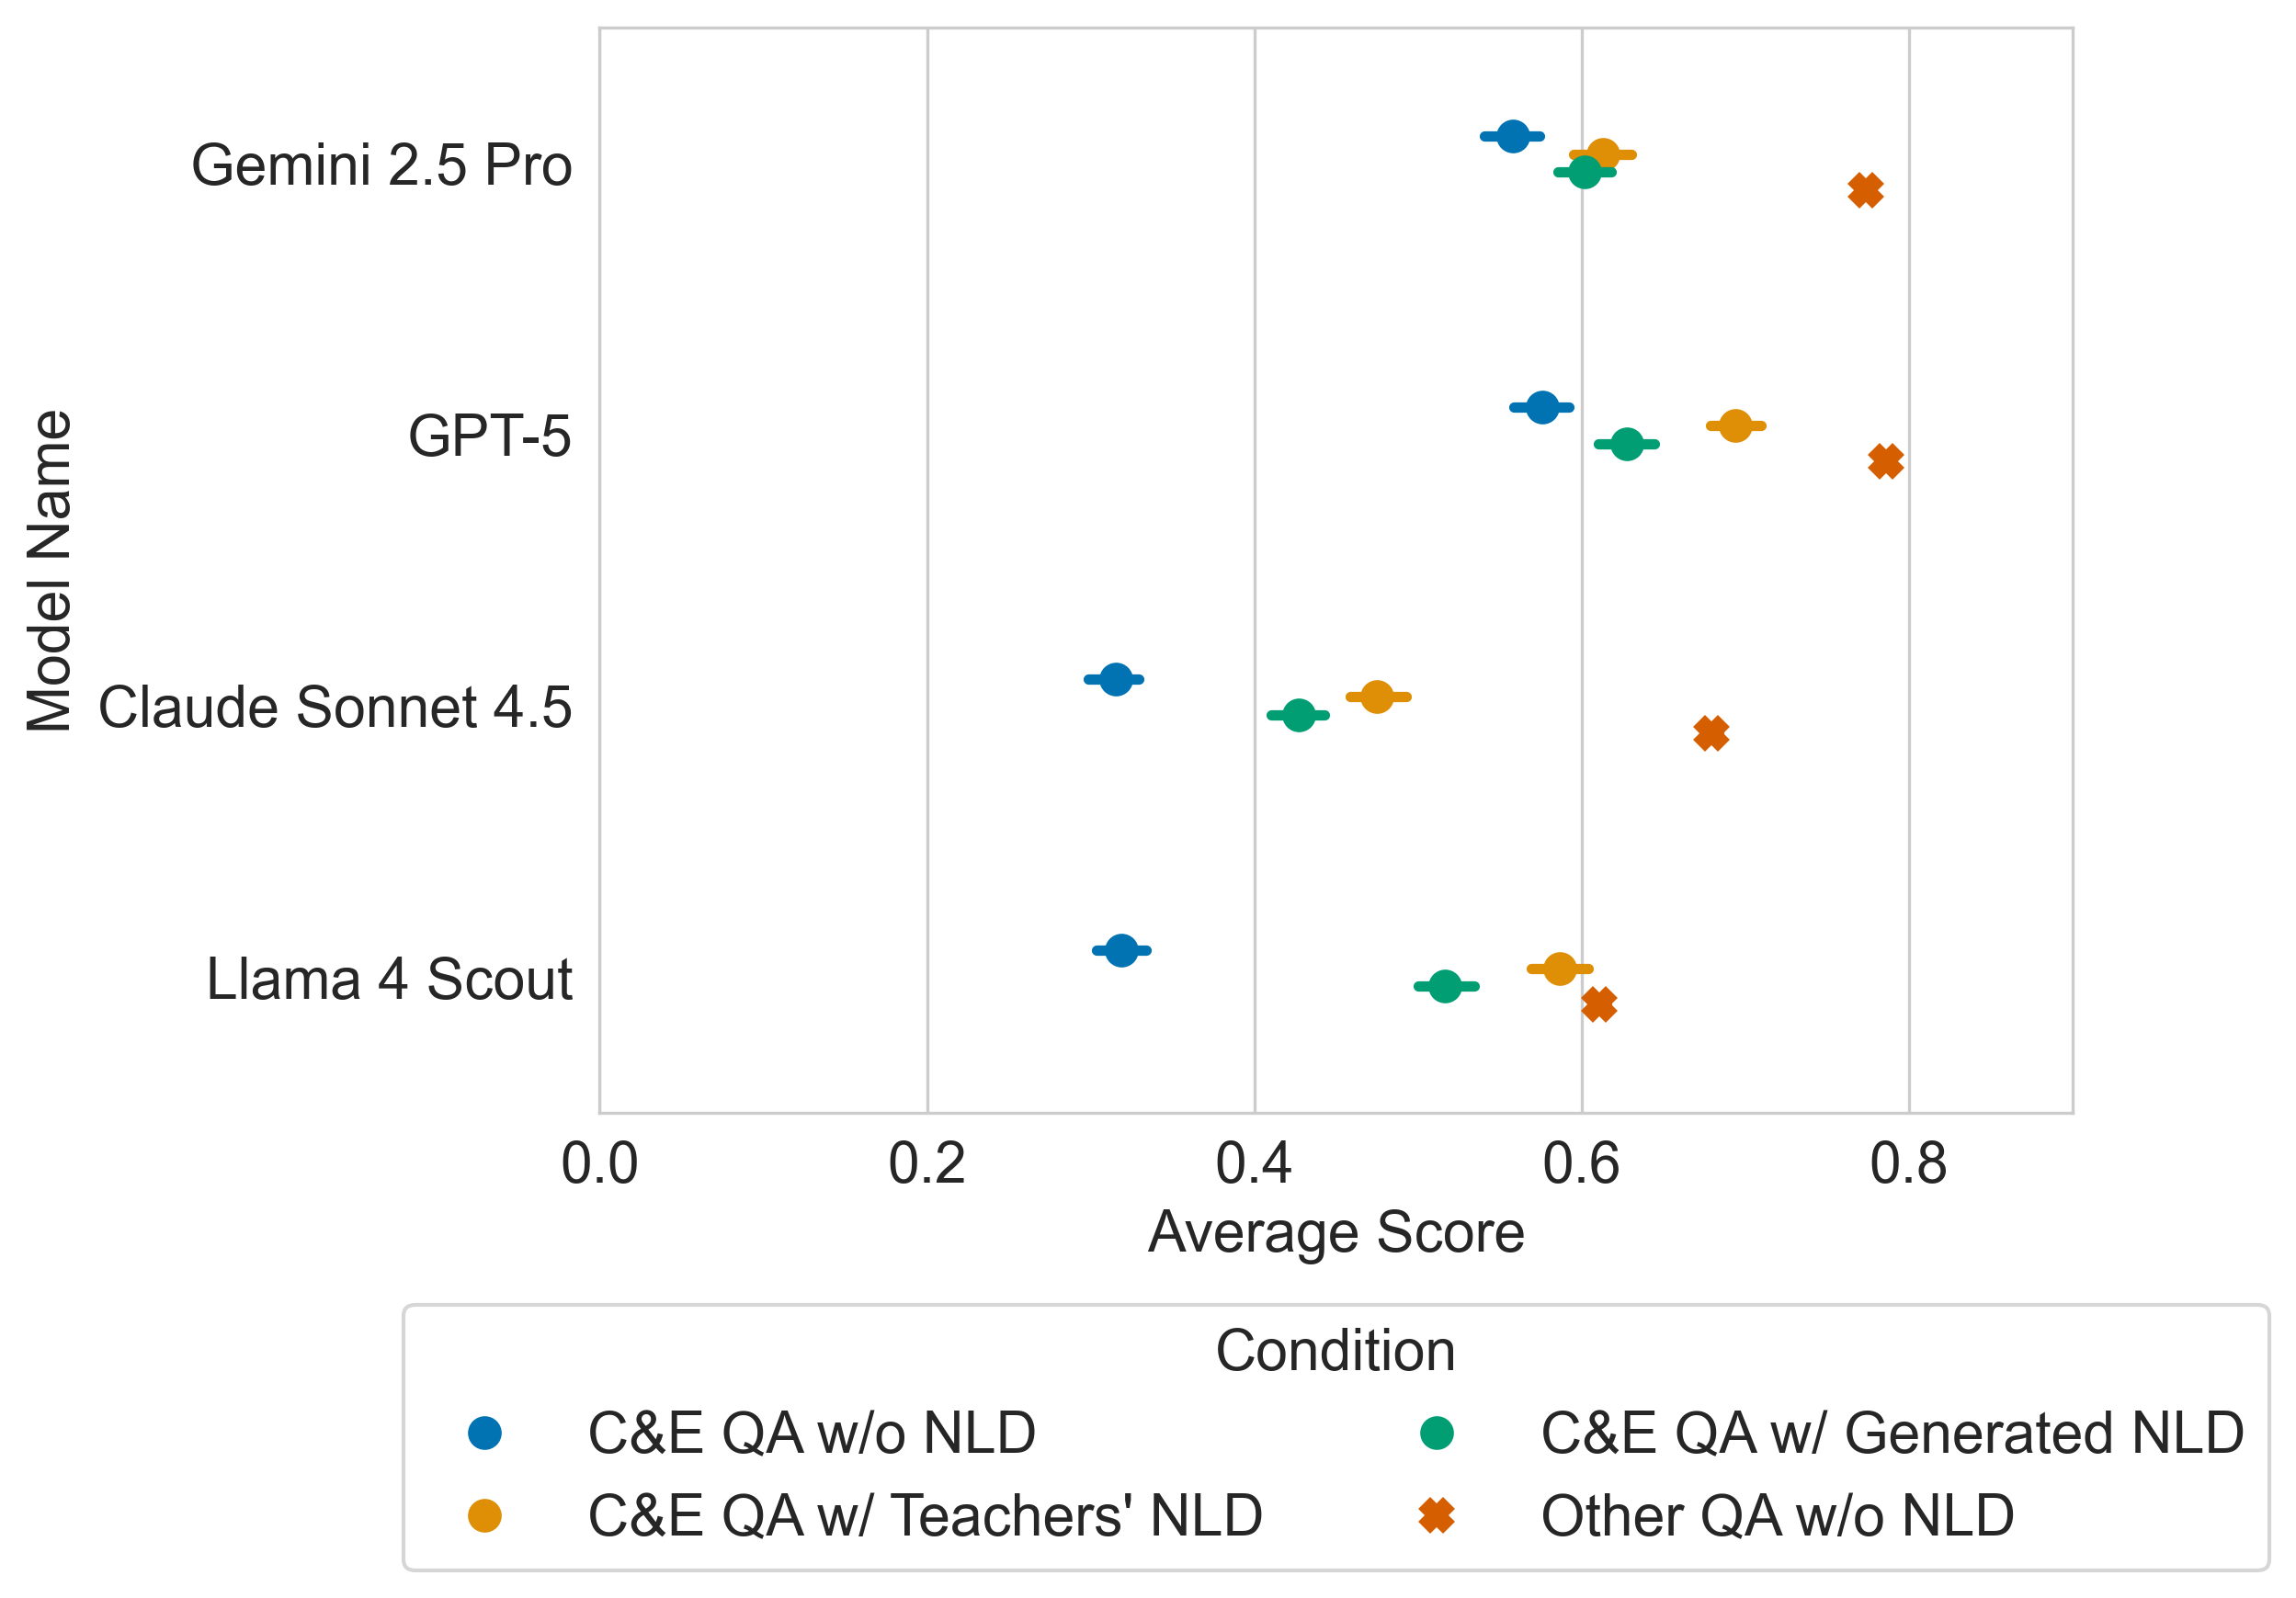

In [45]:
exp2_df['Results'] = 'C&E QA w/o NLD'
exp2_nl_df['Results'] = 'C&E QA w/ Teachers\' NLD'
exp2_testtime_df['Results'] = 'C&E QA w/ Generated NLD'
exp2_results = pd.concat([exp2_df, exp2_nl_df, exp2_testtime_df, exp2_df_other], ignore_index=True)

sns.set_style("whitegrid")
palette = sns.color_palette("colorblind")
plt.figure(figsize=(8, 6), dpi=300)
sns.pointplot(data=exp2_results, y='Model Name', x='Score', 
              dodge=0.2, linestyle="none", hue='Results', markers=['o', 'o', 'o', 'X'], palette=palette)
plt.xlabel("Average Score", fontsize=15)
plt.ylabel("Model Name", fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.xlim(0, 0.9)
plt.legend(title="Condition", title_fontsize=15, fontsize=15, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.tight_layout()
plt.show()

### Answer Defaults

In [33]:
other_question_df = pred_subset_df[pred_subset_df['Question Cat'] != 'Correctness and errors']
other_question_df = other_question_df[other_question_df['Question Cat'] != 'Image creation and medium']

In [34]:
tups = [] # (model name, problem id, question, ans1, ans2)
for model_name in ['Gemini 2.5 Pro', 'Claude Sonnet 4.5', 'GPT-5', 'Llama 4 Scout']:
    this_model_df = other_question_df[other_question_df['Model Name'] == model_name] # any one model
    model_answers = this_model_df.groupby(['Problem ID', 'Question', 'Has Error', 'Score'])['Model Answer'].apply(list).to_dict()
    true_answers = this_model_df.groupby(['Problem ID', 'Question', 'Has Error', 'Score'])['Reference Answer'].apply(list).to_dict()
    example_count = 0
    for problem_id in this_model_df['Problem ID'].unique(): 
        questions = this_model_df[this_model_df['Problem ID'] == problem_id]['Question'].unique()
        for q in questions: 
            key = (problem_id, q, 'error', 0)
            if key in model_answers:
                alternate_key = (problem_id, q, 'no error', 0) 
                true_answers1 = true_answers.get(alternate_key, []) 
                alternate_key = (problem_id, q, 'no error', 1)
                true_answers2 = true_answers.get(alternate_key, [])
                # there should be at least two true answers
                if len(true_answers1) + len(true_answers2) < 2:
                    continue
                common_true_answers = Counter(true_answers1 + true_answers2)
                for ans1 in model_answers[key]: 
                    for ans2 in common_true_answers: 
                        tups.append((model_name, problem_id, q, ans1, ans2))
                example_count += 1
    print("Number of examples:", model_name, example_count)
print(len(tups))

Number of examples: Gemini 2.5 Pro 589
Number of examples: Claude Sonnet 4.5 652
Number of examples: GPT-5 567
Number of examples: Llama 4 Scout 718
26486


In [35]:
with open(Path.cwd().parent / 'data' / 'answer_comparisons.json', 'r') as infile:
    answer_comparisons = json.load(infile)

In [36]:
missing_comparisons = []
for model_name in ['Gemini 2.5 Pro', 'Claude Sonnet 4.5', 'GPT-5', 'Llama 4 Scout']:
    this_model_df = other_question_df[other_question_df['Model Name'] == model_name] # any one model
    model_answers = this_model_df.groupby(['Problem ID', 'Question', 'Has Error', 'Score'])['Model Answer'].apply(list).to_dict()
    true_answers = this_model_df.groupby(['Problem ID', 'Question', 'Has Error', 'Score'])['Reference Answer'].apply(list).to_dict()
    incorrect_pred_matches_nonerroneous = 0 # the % of times for which an incorrect model response for an erroneous student image matched the majority (> 50%) of true answers for non-erroneous student images
    total_incorrect_pred = 0
    for problem_id in this_model_df['Problem ID'].unique(): 
        questions = this_model_df[this_model_df['Problem ID'] == problem_id]['Question'].unique()
        for q in questions: 
            key = (problem_id, q, 'error', 0)
            if key in model_answers:
                alternate_key = (problem_id, q, 'no error', 0) 
                true_answers1 = true_answers.get(alternate_key, []) 
                alternate_key = (problem_id, q, 'no error', 1)
                true_answers2 = true_answers.get(alternate_key, [])
                # there should be at least two true answers
                if len(true_answers1) + len(true_answers2) < 2:
                    continue
                common_true_answers = Counter(true_answers1 + true_answers2)
                for ans1 in model_answers[key]: 
                    this_total = 0
                    if ans1 != ans1: continue # there is a nan
                    for ans2 in common_true_answers:
                        key = " @@@@ ".join([ans1.strip(), ans2.strip()])
                        is_match = answer_comparisons[q.strip()][key]
                        if is_match == 1:
                            this_total += common_true_answers[ans2]
                    frac = this_total / len(common_true_answers)
                    if frac > 0.5:
                        incorrect_pred_matches_nonerroneous += 1
                    total_incorrect_pred += 1
    percent = incorrect_pred_matches_nonerroneous/total_incorrect_pred
    print(model_name, f"{percent:.4f}")

Gemini 2.5 Pro 0.2923
Claude Sonnet 4.5 0.3519
GPT-5 0.3125
Llama 4 Scout 0.3060


### Open-ended vs. binary error & correctness

In [37]:
question_type_to_question = defaultdict(list)
with open(Path.cwd().parent / 'data' / 'question_binary.json', 'r') as infile:
    question_binary = json.load(infile)
    for k in question_binary:
        question_type_to_question[question_binary[k]].append(k)

random.seed(1234)
for question_type in question_type_to_question:
    print(question_type, len(question_type_to_question[question_type]))
    for sample in random.sample(question_type_to_question[question_type], 10): 
        print(f"{question_type}: {sample}")

binary 650
binary: Did the student correctly round 283 to 300 and 416 to 400?
binary: Did the student answer the question correctly or incorrectly?
binary: Is the total number of tennis balls drawn by the student correct or incorrect?
binary: Did the student arrange the array as required by the question?
binary: Is the student's final answer correct or incorrect?
binary: Are the numbers plotted correctly given the scale?
binary: Is the fraction the student wrote correct or incorrect?
binary: Is the second equation (1,000 divided by 59,000 equals 59) correct or incorrect?
binary: Is writing 17 below 0 correct, and what should be written instead?
binary: Did the student correctly solve the two-step equation to get 3.8?
other 202
other: What starting value has the student mistakenly drawn instead of negative 2?
other: What incorrect calculation did the student make with the absolute value of 17?
other: What is the incorrect sum of row 3?
other: What is the error the student makes in their

In [38]:
error_question_types = {}
for question_type in question_type_to_question:
    for question in question_type_to_question[question_type]:
        if question.startswith('What errors does the student make in their response?'): 
            error_question_types[question] = 'generic'
        else: 
            error_question_types[question] = question_type

In [39]:
def map_to_correctness_question_cat(q): 
    q = q.strip()
    if q.startswith('What errors does the student make in their response?'): 
        q = 'What errors does the student make in their response?'
    return error_question_types[q]

correctness_df = pred_subset_df[pred_subset_df['Question Cat'] == 'Correctness and errors']
correctness_df['Correctness Question Type'] = correctness_df['Question'].apply(map_to_correctness_question_cat)

/var/folders/hh/syyyddsn7w33p6pntgdg0yq00000gn/T/ipykernel_79847/2834611191.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correctness_df['Correctness Question Type'] = correctness_df['Question'].apply(map_to_correctness_question_cat)


In [40]:
correctness_df[correctness_df['Model Name'] == 'Gemini 2.5 Pro']['Correctness Question Type'].value_counts()

Correctness Question Type
binary     2274
generic    2030
other       204
Name: count, dtype: int64

/var/folders/hh/syyyddsn7w33p6pntgdg0yq00000gn/T/ipykernel_79847/2498801453.py:17: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.barplot(data=correctness_df, y='Model Name', x='Score', dodge=0.2, linestyle="none",


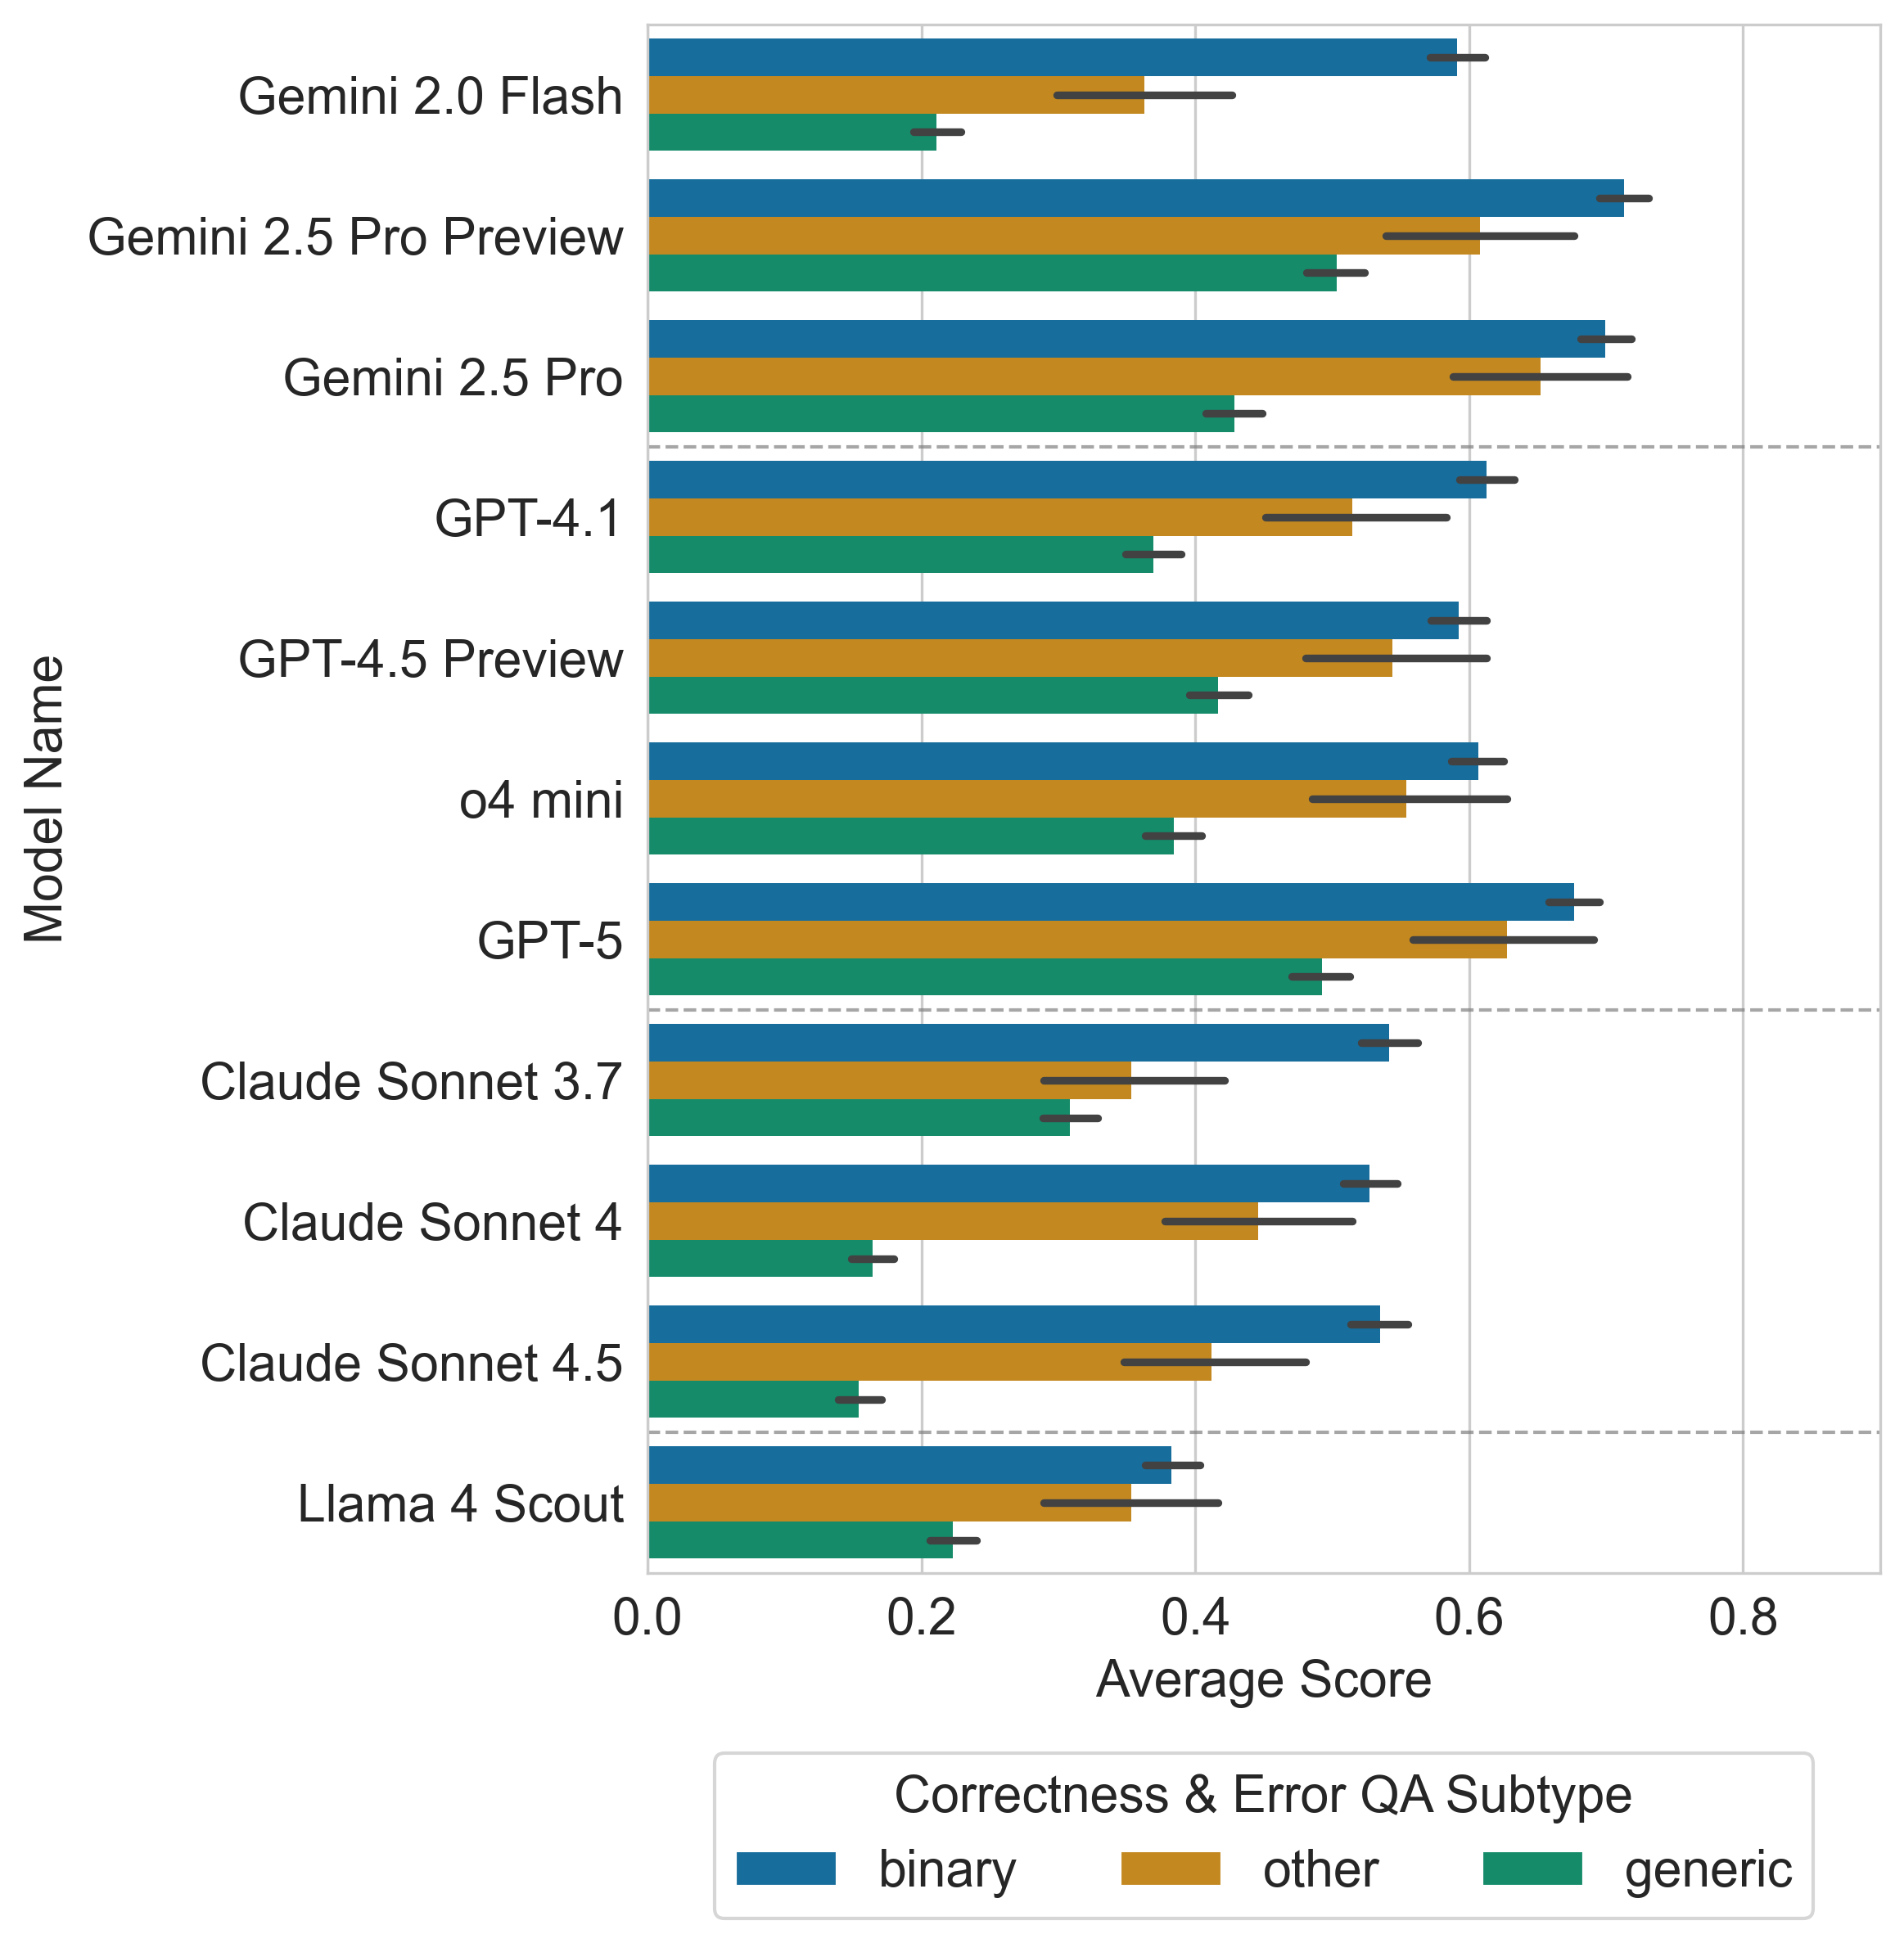

In [41]:
sns.set_style("whitegrid")
palette = sns.color_palette("colorblind")
plt.figure(figsize=(8, 8), dpi=300)
yorder = [
    "Gemini 2.0 Flash",
    "Gemini 2.5 Pro Preview",
    "Gemini 2.5 Pro",
    "GPT-4.1",
    "GPT-4.5 Preview",
    "o4 mini",
    "GPT-5",
    "Claude Sonnet 3.7",
    "Claude Sonnet 4",
    "Claude Sonnet 4.5",
    "Llama 4 Scout"
]
sns.barplot(data=correctness_df, y='Model Name', x='Score', dodge=0.2, linestyle="none", 
            order=yorder,
            hue='Correctness Question Type', palette=palette, hue_order=['binary', 'other', 'generic'])
plt.axhline(y=2.5, color='gray', linestyle='--', linewidth=1, alpha=0.7)  # After Gemini 2.5 Pro
plt.axhline(y=6.5, color='gray', linestyle='--', linewidth=1, alpha=0.7)  # After GPT-5
plt.axhline(y=9.5, color='gray', linestyle='--', linewidth=1, alpha=0.7)  # After Claude Sonnet 4.5
plt.xlabel("Average Score", fontsize=15)
plt.ylabel("Model Name", fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.xlim(0, 0.9)
plt.legend(title="Correctness & Error QA Subtype", title_fontsize=15, fontsize=15, loc='upper center', 
           bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.tight_layout()
plt.show()

In [42]:
with open(Path.cwd().parent / 'data' / 'binary_correctness.json', 'r') as infile:
    binary_correctness = json.load(infile)
print(len(binary_correctness))

647


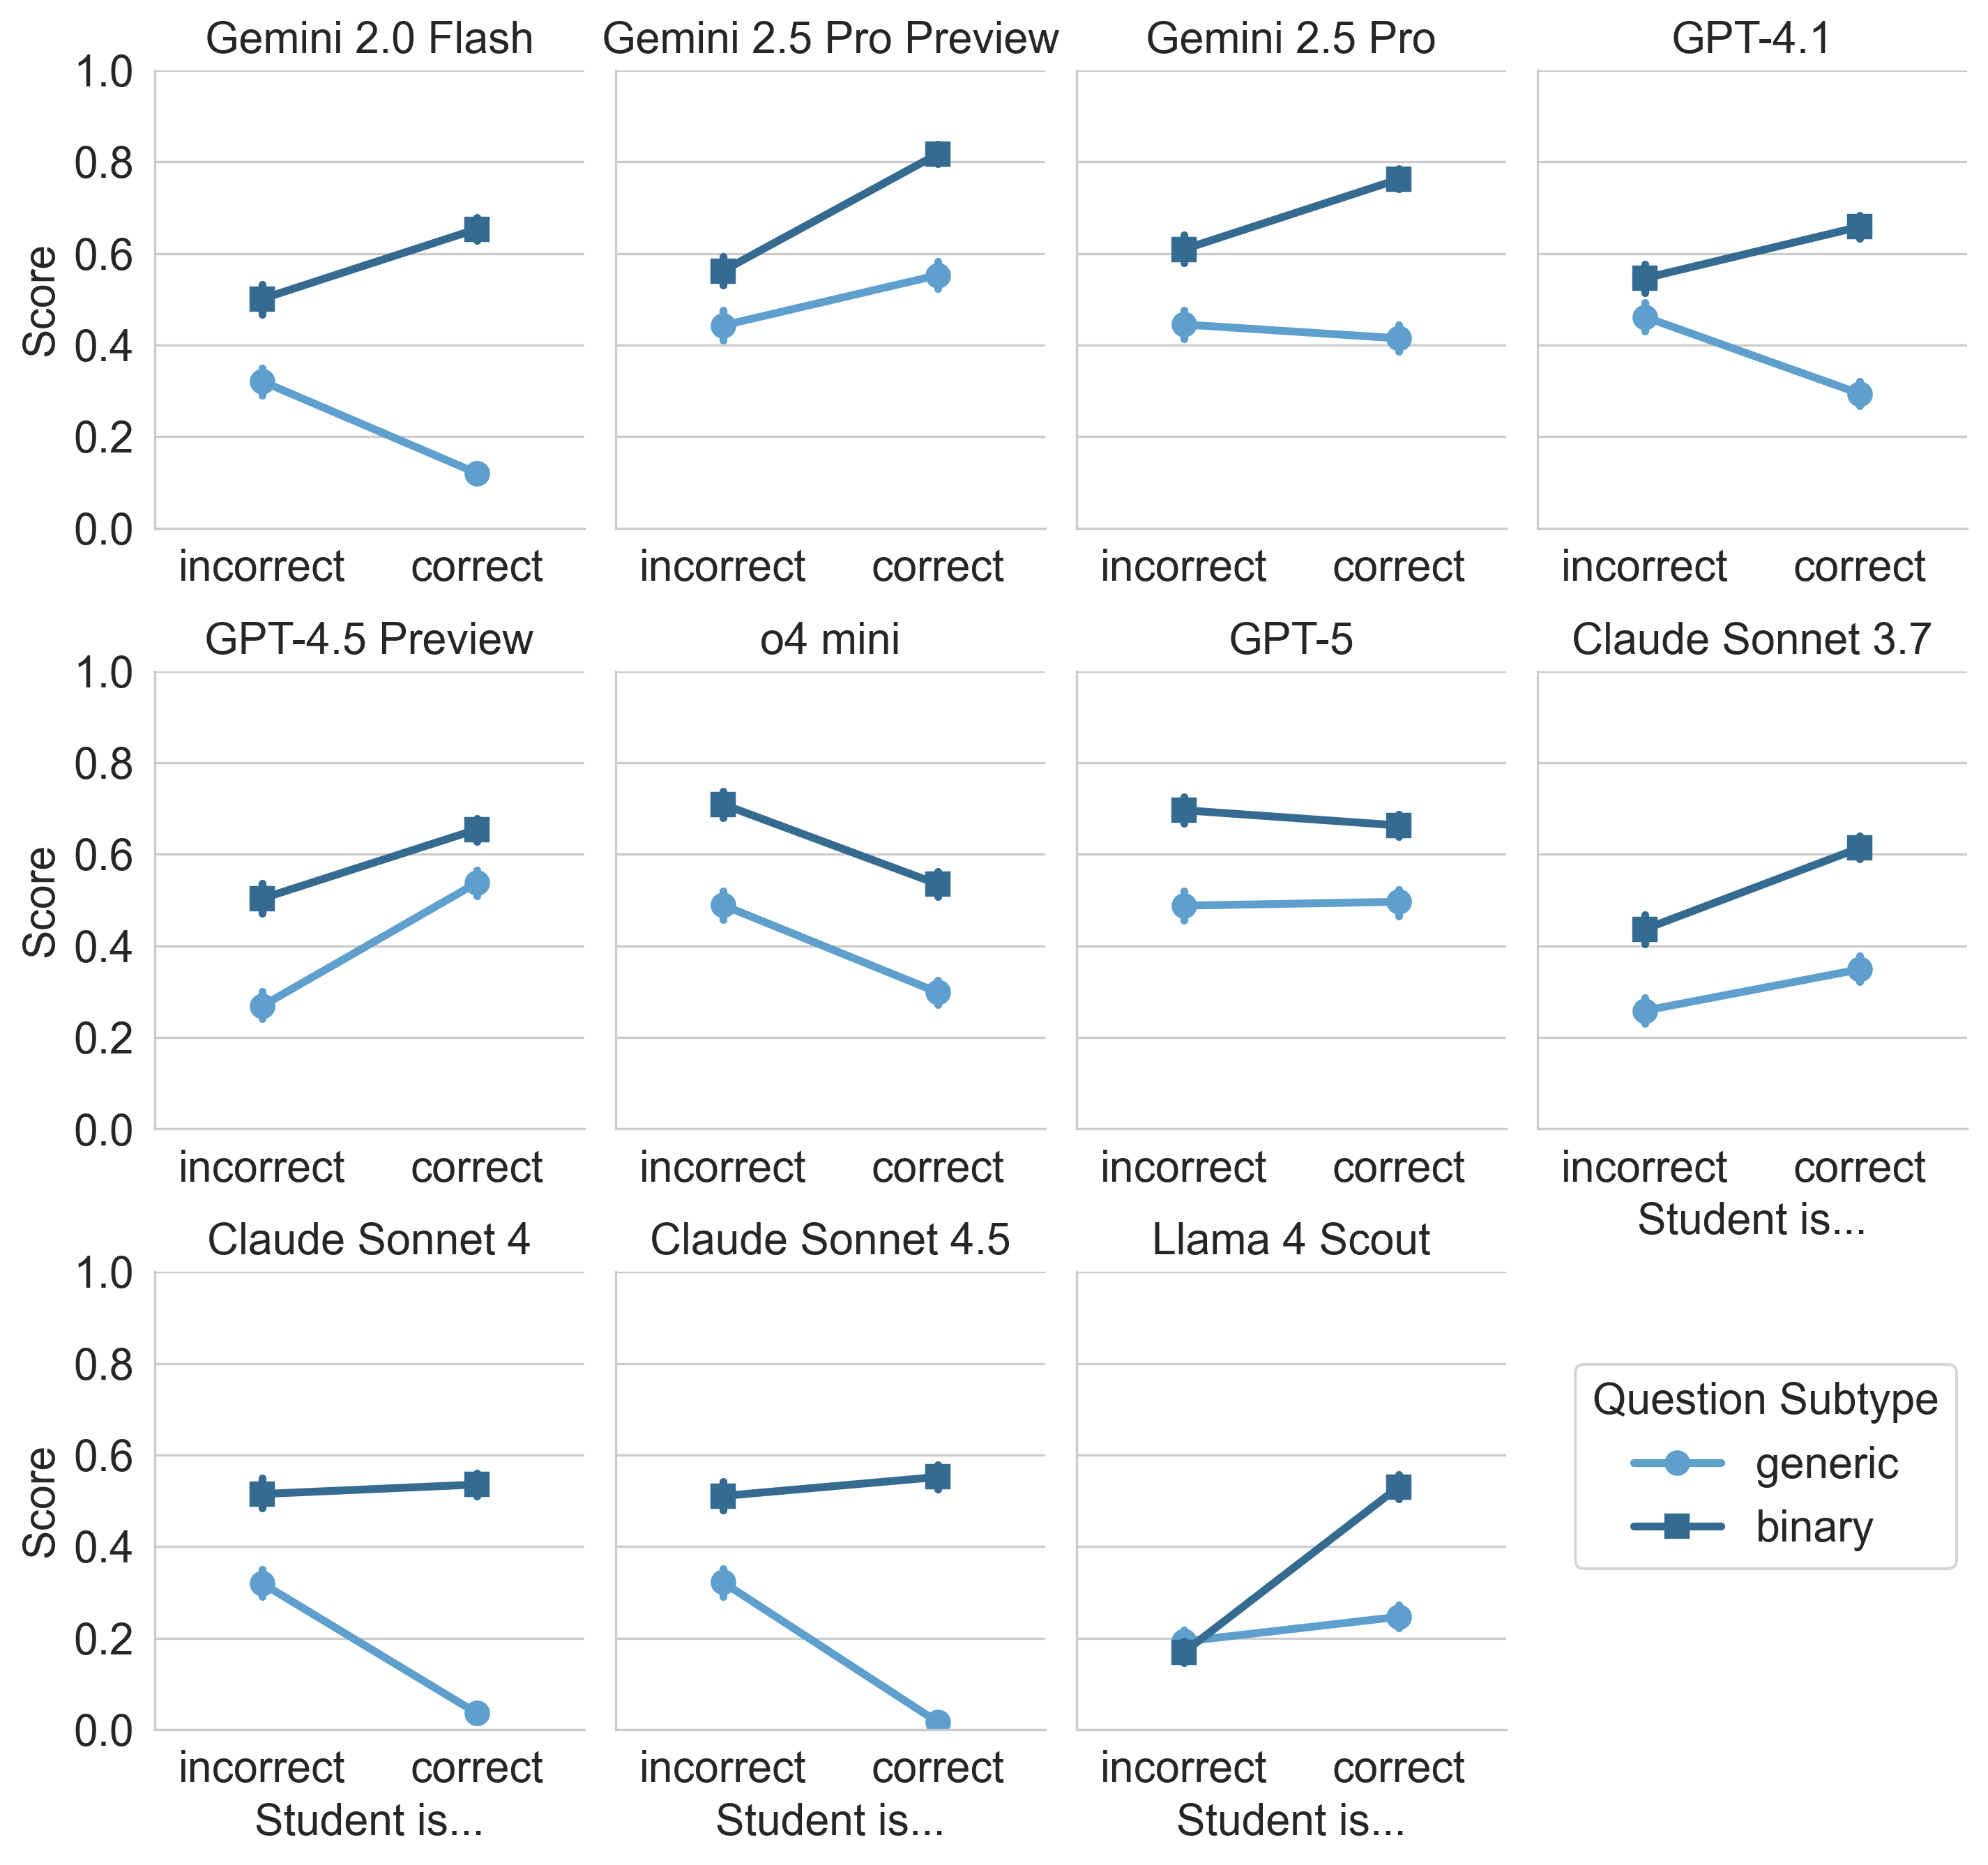

In [43]:
sns.set_style("whitegrid")

yorder = [
    "Gemini 2.0 Flash",
    "Gemini 2.5 Pro Preview",
    "Gemini 2.5 Pro",
    "GPT-4.1",
    "GPT-4.5 Preview",
    "o4 mini",
    "GPT-5",
    "Claude Sonnet 3.7",
    "Claude Sonnet 4",
    "Claude Sonnet 4.5",
    "Llama 4 Scout"
]

generic_df = correctness_df[correctness_df['Correctness Question Type'] == 'generic']
generic_df = generic_df.copy()
generic_df['Student is...'] = generic_df['Has Error'].apply(lambda x: 'incorrect' if x == 'error' else 'correct')
generic_df['Question Subtype'] = 'generic'
correct_bin_df = correctness_df[correctness_df['Correctness Question Type'] == 'binary']
correct_bin_df = correct_bin_df.copy()
correct_bin_df['Binary Correctness'] = correct_bin_df.apply(lambda row: binary_correctness[row['Question'].strip()][row['Reference Answer'].strip()], axis=1)
correct_bin_df['Student is...'] = correct_bin_df.apply(lambda x: 'incorrect' if x['Binary Correctness'] == 'incorrect' else 'correct', axis=1)
correct_bin_df['Question Subtype'] = 'binary'
this_df = pd.concat([generic_df, correct_bin_df], ignore_index=True)

# Create FacetGrid with 3 rows x 4 columns (col_wrap=4)
g = sns.FacetGrid(
    this_df, 
    col='Model Name', 
    col_order=yorder,
    col_wrap=4,
    height=3, 
    aspect=0.8,
    sharey=True,
    sharex=False
)

# Map pointplot with x=Has Error, y=Score
g.map_dataframe(
    sns.pointplot, 
    x='Student is...', 
    y='Score',
    order=['incorrect', 'correct'],
    hue='Question Subtype',
    markers=['o', 's'],
    palette='Blues_d',
    linestyle="-"
)

g.set_xlabels("Student is...", fontsize=15)
g.set_ylabels("Score", fontsize=15)
g.set(ylim=(0, 1.0))
g.set_titles("{col_name}", size=15)

for ax in g.axes.flat:
    ax.tick_params(axis='both', labelsize=15)
# add legend in bottom right corner
handles, labels = g.axes[0].get_legend_handles_labels()
g.fig.legend(handles, labels, title="Question Subtype", title_fontsize=15, 
             fontsize=15, loc='lower right', bbox_to_anchor=(0.99, 0.15))

plt.tight_layout()
g.fig.set_dpi(300)
plt.show()